In [2]:

from __future__ import print_function
import os
import matplotlib as mpl
import tarfile
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils
from mxnet import autograd
import numpy as np



# Parameters( not to be touched)

In [3]:
epochs = 20 # Set low by default for tests, set higher when you actually run this code.
batch_size = 64
latent_z_size = 100

np.random.seed(19)
mx.random.seed(19)

use_gpu = False
ctx = mx.gpu() if use_gpu else mx.cpu()

lr = 0.0002
beta1 = 0.5

# Data Processing

In [4]:
from zipfile import ZipFile
import numpy as np

def load_data(mode = 'train'):
    label_filename = mode + '_labels'
    image_filename = mode + '_images'
    label_zip = './data/' + label_filename + '.zip'
    image_zip = './data/' + image_filename + '.zip'
    with ZipFile(label_zip, 'r') as lblzip:
        labels = np.frombuffer(lblzip.read(label_filename), dtype=np.uint8, offset=8)
    with ZipFile(image_zip, 'r') as imgzip:
        images = np.frombuffer(imgzip.read(image_filename), dtype=np.uint8, offset=16).reshape(len(labels), 784)
    return images, labels


In [5]:
images, labels = load_data()
print(images.shape)
print(labels.shape)
index = np.random.randint(images.shape[0], size=60000)
images = images[index, :]
labels = labels[index]
print(images.shape)
print(labels.shape)

(60000, 784)
(60000,)
(60000, 784)
(60000,)


In [6]:
from mxnet import nd
target_wd = 28
target_ht = 28
img_list = []

def transform(data, target_wd, target_ht):
    # resize to target_wd * target_ht
    data = mx.image.imresize(data, target_wd, target_ht)
    # transpose from (target_wd, target_ht, 3)
    # to (3, target_wd, target_ht)
    data = nd.transpose(data, (2,0,1))
    # normalize to [-1, 1]
    data = data.astype(np.float32)/127.5 - 1
    # if image is greyscale, repeat 3 times to get RGB image.
    if data.shape[0] == 1:
        data = nd.tile(data, (3, 1, 1))
    return data.reshape((1,) + data.shape)

for img in images:
    img_arr = nd.array(img).reshape((28,28,1))
    img_arr = transform(img_arr, target_wd, target_ht)
    img_list.append(img_arr)
    

In [7]:
train_data = mx.io.NDArrayIter(data=nd.concatenate(img_list),label = nd.array(labels), batch_size=batch_size)

In [8]:
len(img_list)
labels[5]

0

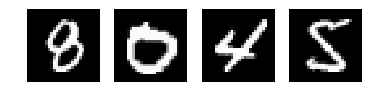

In [9]:
def visualize(img_arr):
    plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')

for i in range(4):
    plt.subplot(1,4,i+1)
    visualize(img_list[i + 10][0])
plt.show()

# Conditional DCGANs
To make model conditional: <br>
    Input to Genrator : 'y' vector = OHE of a label, appended with latent z,<br>
    Output Generator : (batch_size ,3 x 28 x 28) image<br>
    Input to Generator : Concatenate ( ['y' vector = (OHE of a label).reshape(batch_size,3,1,28)] , output generator/real image , axis = 2)<br>
    Output Generator : {0,1}<br>

## Model 1
( Convolution layers  and filters (you can't change one without other, since you eventually need to make a 28 x 28 image out of Generator and a single output out of Descriminator, and no Fully connected layers ) are messed with, Well this I had to since the input to convolution in the tutorial was (64 x 64), while we use (28 x 28) )

In [10]:
# build the generator
nc = 3
ngf = 28
netG = nn.Sequential()
with netG.name_scope():
    # input is Z, going into a convolution
    netG.add(nn.Conv2DTranspose(ngf * 8, 4, 1, 0, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 4 x 4
    netG.add(nn.Conv2DTranspose(ngf * 4, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*4) x 8 x 8
    netG.add(nn.Conv2DTranspose(ngf * 2, 3, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*2) x 15 x 15
    netG.add(nn.Conv2DTranspose(nc, 2, 2, 1, use_bias=False))
    netG.add(nn.Activation('tanh'))
    # state size. (nc) x 28 x 28

# build the discriminator
ndf = 28
netD = nn.Sequential()
with netD.name_scope():
    # input is (nc) x 29 x 28
    netD.add(nn.Conv2D(ndf, (4,3), 2, 1, use_bias=False))
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 14 x 14
    netD.add(nn.Conv2D(ndf * 2, 3, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf*2) x 7 x 7
    netD.add(nn.Conv2D(ndf * 4, 3, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf*8) x 4 x 4
    netD.add(nn.Conv2D(1, 4, 1, 0, use_bias=False))
    #state size. (1) x 1 x 1

In [11]:
# loss
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

# initialize the generator and the discriminator
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})



In [12]:
'''
def img_label_data(data,label):   #for image and label combine, not z and label
    data = data.asnumpy()
    label_temp = nd.array(label).asnumpy().astype(int)
    label = np.zeros((batch_size,28))
    label[np.arange(batch_size),label_temp]=1
    label = label.reshape((batch_size,1,1,28))
    label = np.tile(label, (1,3, 1, 1))
    return nd.array(np.concatenate((data,label),axis = 2), ctx = ctx)
'''


'\ndef img_label_data(data,label):   #for image and label combine, not z and label\n    data = data.asnumpy()\n    label_temp = nd.array(label).asnumpy().astype(int)\n    label = np.zeros((batch_size,28))\n    label[np.arange(batch_size),label_temp]=1\n    label = label.reshape((batch_size,1,1,28))\n    label = np.tile(label, (1,3, 1, 1))\n    return nd.array(np.concatenate((data,label),axis = 2), ctx = ctx)\n'

In [13]:
def img_label_data_nd(data,label):   #for image and label combine, not z and label
    label_temp = nd.array(label).astype(int)
    label = nd.zeros((batch_size,28))
    label[nd.arange(batch_size).astype(int),label_temp]=1
    label = label.reshape((batch_size,1,1,28))
    label = nd.tile(label, (1,3, 1, 1))
    return nd.array(nd.concat(data,label ,dim = 2), ctx = ctx)

In [14]:
i=0
train_data.reset()
for batch in train_data:
    if(i == 0):
        i+=1
    else:
        break
    data = batch.data[0]
    label = batch.label[0]
    print(img_label_data_nd(data,label).shape)

(64, 3, 29, 28)


In [15]:
from datetime import datetime
import time
import logging
import numpy as np

real_label = nd.ones((batch_size,), ctx=ctx)
fake_label = nd.zeros((batch_size,),ctx=ctx)

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()
metric = mx.metric.CustomMetric(facc)

stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
logging.basicConfig(level=logging.DEBUG)

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    train_data.reset()
    iter = 0
    for batch in train_data:
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        data = nd.array(batch.data[0])
        mnist_label = nd.array(batch.label[0])
        
        latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1)).asnumpy()
        y_z_label = np.random.randint(0,10,batch_size)
        
        y = np.zeros((batch_size,28))
        y[np.arange(batch_size),y_z_label] = 1
        y = y.reshape((batch_size,28,1,1))
        
        latent_z = np.concatenate((latent_z,y),axis = 1)
        latent_z = nd.array(latent_z, ctx = ctx)

        with autograd.record():
            # train with real image
            G_data = img_label_data_nd(data,mnist_label)
            
            output = netD(G_data).reshape((-1, 1))
            errD_real = loss(output, real_label)
            metric.update([real_label,], [output,])

            # train with fake image
            fake = netG(latent_z)
            
            G_fake_data = img_label_data_nd(fake.detach(),y_z_label)
            
            output = netD(G_fake_data).reshape((-1, 1))
            errD_fake = loss(output, fake_label)
            errD = errD_real + errD_fake
            errD.backward()
            metric.update([fake_label,], [output,])

        trainerD.step(batch.data[0].shape[0])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        
        with autograd.record():
            # train with fake image
            fake = netG(latent_z)
            G_fake_data = img_label_data_nd(fake,y_z_label)
            
            output = netD(G_fake_data).reshape((-1, 1))
            errG = loss(output, real_label)
            errG.backward()

        trainerG.step(batch.data[0].shape[0])
        
        # Print log infomation every ten batches
        if iter % 10 == 0:
            name, acc = metric.get()
            logging.info('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
            logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d'
                     %(nd.mean(errD).asscalar(),
                       nd.mean(errG).asscalar(), acc, iter, epoch))
        iter = iter + 1
        btic = time.time()

    name, acc = metric.get()
    metric.reset()
    # logging.info('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
    # logging.info('time: %f' % (time.time() - tic))

    # Visualize one generated image for each epoch
    # fake_img = fake[0]
    # visualize(fake_img)
    # plt.show()

INFO:root:speed: 314.9582547703889 samples/s
INFO:root:discriminator loss = 1.468499, generator loss = 0.857795, binary training acc = 0.445312 at iter 0 epoch 0
INFO:root:speed: 180.0042353076868 samples/s
INFO:root:discriminator loss = 0.837869, generator loss = 1.235961, binary training acc = 0.753551 at iter 10 epoch 0
INFO:root:speed: 182.51851529512555 samples/s
INFO:root:discriminator loss = 0.492655, generator loss = 1.765542, binary training acc = 0.857515 at iter 20 epoch 0
INFO:root:speed: 181.4778185515602 samples/s
INFO:root:discriminator loss = 0.446439, generator loss = 2.041416, binary training acc = 0.894405 at iter 30 epoch 0
INFO:root:speed: 181.3131960875565 samples/s
INFO:root:discriminator loss = 0.367410, generator loss = 2.273908, binary training acc = 0.915587 at iter 40 epoch 0
INFO:root:speed: 182.06234743949295 samples/s
INFO:root:discriminator loss = 0.285142, generator loss = 2.588826, binary training acc = 0.928922 at iter 50 epoch 0
INFO:root:speed: 175.

INFO:root:speed: 167.231583905027 samples/s
INFO:root:discriminator loss = 0.144684, generator loss = 2.933944, binary training acc = 0.972165 at iter 500 epoch 0
INFO:root:speed: 182.61499245213963 samples/s
INFO:root:discriminator loss = 4.056906, generator loss = 0.106381, binary training acc = 0.971578 at iter 510 epoch 0
INFO:root:speed: 182.01000651596547 samples/s
INFO:root:discriminator loss = 0.926436, generator loss = 1.676648, binary training acc = 0.964986 at iter 520 epoch 0
INFO:root:speed: 181.67507197686993 samples/s
INFO:root:discriminator loss = 0.670469, generator loss = 1.809244, binary training acc = 0.962482 at iter 530 epoch 0
INFO:root:speed: 177.65793583980602 samples/s
INFO:root:discriminator loss = 0.497170, generator loss = 2.258892, binary training acc = 0.962410 at iter 540 epoch 0
INFO:root:speed: 181.0262210575013 samples/s
INFO:root:discriminator loss = 0.369664, generator loss = 2.785451, binary training acc = 0.962327 at iter 550 epoch 0
INFO:root:spe

INFO:root:speed: 169.84587194275102 samples/s
INFO:root:discriminator loss = 0.783286, generator loss = 1.386725, binary training acc = 0.871926 at iter 60 epoch 1
INFO:root:speed: 180.80467389744933 samples/s
INFO:root:discriminator loss = 0.675146, generator loss = 1.830913, binary training acc = 0.874230 at iter 70 epoch 1
INFO:root:speed: 181.67261288405757 samples/s
INFO:root:discriminator loss = 0.651468, generator loss = 1.497287, binary training acc = 0.874035 at iter 80 epoch 1
INFO:root:speed: 182.81933379191042 samples/s
INFO:root:discriminator loss = 0.442282, generator loss = 1.725882, binary training acc = 0.880495 at iter 90 epoch 1
INFO:root:speed: 182.57971741970852 samples/s
INFO:root:discriminator loss = 0.634968, generator loss = 1.159454, binary training acc = 0.884360 at iter 100 epoch 1
INFO:root:speed: 182.08803512668166 samples/s
INFO:root:discriminator loss = 0.302061, generator loss = 2.149046, binary training acc = 0.891962 at iter 110 epoch 1
INFO:root:spee

INFO:root:speed: 181.20426597326713 samples/s
INFO:root:discriminator loss = 0.515947, generator loss = 2.352297, binary training acc = 0.915246 at iter 560 epoch 1
INFO:root:speed: 180.81185926019728 samples/s
INFO:root:discriminator loss = 0.704942, generator loss = 1.677945, binary training acc = 0.911627 at iter 570 epoch 1
INFO:root:speed: 180.66996280736421 samples/s
INFO:root:discriminator loss = 0.570656, generator loss = 2.486900, binary training acc = 0.911279 at iter 580 epoch 1
INFO:root:speed: 180.86010122515862 samples/s
INFO:root:discriminator loss = 0.482146, generator loss = 1.514241, binary training acc = 0.911405 at iter 590 epoch 1
INFO:root:speed: 181.38266145924834 samples/s
INFO:root:discriminator loss = 0.499058, generator loss = 1.391623, binary training acc = 0.911879 at iter 600 epoch 1
INFO:root:speed: 178.07077179237993 samples/s
INFO:root:discriminator loss = 0.361491, generator loss = 2.096088, binary training acc = 0.912605 at iter 610 epoch 1
INFO:root:

INFO:root:speed: 180.242822965704 samples/s
INFO:root:discriminator loss = 0.540096, generator loss = 2.170743, binary training acc = 0.903796 at iter 120 epoch 2
INFO:root:speed: 181.80242095788552 samples/s
INFO:root:discriminator loss = 0.415011, generator loss = 1.414425, binary training acc = 0.906131 at iter 130 epoch 2
INFO:root:speed: 179.24579539164105 samples/s
INFO:root:discriminator loss = 0.448854, generator loss = 2.445454, binary training acc = 0.908134 at iter 140 epoch 2
INFO:root:speed: 177.49993288426404 samples/s
INFO:root:discriminator loss = 0.737042, generator loss = 1.201651, binary training acc = 0.897868 at iter 150 epoch 2
INFO:root:speed: 174.28361366088785 samples/s
INFO:root:discriminator loss = 0.605545, generator loss = 2.501365, binary training acc = 0.899165 at iter 160 epoch 2
INFO:root:speed: 159.57679451137844 samples/s
INFO:root:discriminator loss = 0.554057, generator loss = 1.471624, binary training acc = 0.899762 at iter 170 epoch 2
INFO:root:sp

INFO:root:speed: 173.61282081629935 samples/s
INFO:root:discriminator loss = 0.488904, generator loss = 2.762696, binary training acc = 0.895947 at iter 620 epoch 2
INFO:root:speed: 176.72970510315332 samples/s
INFO:root:discriminator loss = 0.635560, generator loss = 1.634280, binary training acc = 0.895119 at iter 630 epoch 2
INFO:root:speed: 180.62668373107675 samples/s
INFO:root:discriminator loss = 0.556139, generator loss = 2.149383, binary training acc = 0.895293 at iter 640 epoch 2
INFO:root:speed: 180.75281008580583 samples/s
INFO:root:discriminator loss = 0.441908, generator loss = 1.666476, binary training acc = 0.896085 at iter 650 epoch 2
INFO:root:speed: 179.50673997563203 samples/s
INFO:root:discriminator loss = 0.391355, generator loss = 1.786386, binary training acc = 0.896487 at iter 660 epoch 2
INFO:root:speed: 181.33389536713912 samples/s
INFO:root:discriminator loss = 0.431545, generator loss = 1.992710, binary training acc = 0.896016 at iter 670 epoch 2
INFO:root:

INFO:root:speed: 180.4143578493739 samples/s
INFO:root:discriminator loss = 0.744017, generator loss = 1.417614, binary training acc = 0.882122 at iter 180 epoch 3
INFO:root:speed: 181.59371135554923 samples/s
INFO:root:discriminator loss = 0.662855, generator loss = 1.551788, binary training acc = 0.882812 at iter 190 epoch 3
INFO:root:speed: 180.53108134191393 samples/s
INFO:root:discriminator loss = 0.572583, generator loss = 1.759149, binary training acc = 0.882774 at iter 200 epoch 3
INFO:root:speed: 181.00449349710593 samples/s
INFO:root:discriminator loss = 0.659948, generator loss = 1.968779, binary training acc = 0.882664 at iter 210 epoch 3
INFO:root:speed: 158.1135934991147 samples/s
INFO:root:discriminator loss = 0.440471, generator loss = 1.776682, binary training acc = 0.883979 at iter 220 epoch 3
INFO:root:speed: 181.87595855076745 samples/s
INFO:root:discriminator loss = 0.677750, generator loss = 0.933896, binary training acc = 0.885383 at iter 230 epoch 3
INFO:root:sp

INFO:root:speed: 178.0830577413108 samples/s
INFO:root:discriminator loss = 0.773112, generator loss = 0.720107, binary training acc = 0.895696 at iter 680 epoch 3
INFO:root:speed: 180.37762483990576 samples/s
INFO:root:discriminator loss = 0.832567, generator loss = 1.106567, binary training acc = 0.893745 at iter 690 epoch 3
INFO:root:speed: 181.70188040667688 samples/s
INFO:root:discriminator loss = 0.320210, generator loss = 2.020461, binary training acc = 0.893913 at iter 700 epoch 3
INFO:root:speed: 181.71737879548934 samples/s
INFO:root:discriminator loss = 0.539168, generator loss = 2.433435, binary training acc = 0.894757 at iter 710 epoch 3
INFO:root:speed: 181.00290685717562 samples/s
INFO:root:discriminator loss = 0.799182, generator loss = 0.869833, binary training acc = 0.894938 at iter 720 epoch 3
INFO:root:speed: 164.3059212096803 samples/s
INFO:root:discriminator loss = 0.413477, generator loss = 1.905678, binary training acc = 0.895445 at iter 730 epoch 3
INFO:root:sp

INFO:root:speed: 180.89337393686955 samples/s
INFO:root:discriminator loss = 0.404675, generator loss = 4.233389, binary training acc = 0.913447 at iter 240 epoch 4
INFO:root:speed: 180.78299948344915 samples/s
INFO:root:discriminator loss = 0.882368, generator loss = 1.364842, binary training acc = 0.904102 at iter 250 epoch 4
INFO:root:speed: 181.65958080347355 samples/s
INFO:root:discriminator loss = 0.916974, generator loss = 1.194070, binary training acc = 0.900593 at iter 260 epoch 4
INFO:root:speed: 180.87984399489505 samples/s
INFO:root:discriminator loss = 0.528377, generator loss = 2.028659, binary training acc = 0.899389 at iter 270 epoch 4
INFO:root:speed: 180.39920215482712 samples/s
INFO:root:discriminator loss = 0.717107, generator loss = 1.347025, binary training acc = 0.897881 at iter 280 epoch 4
INFO:root:speed: 181.22457334473827 samples/s
INFO:root:discriminator loss = 0.884777, generator loss = 1.405325, binary training acc = 0.896934 at iter 290 epoch 4
INFO:root:

INFO:root:speed: 186.95906805832018 samples/s
INFO:root:discriminator loss = 0.893963, generator loss = 2.918521, binary training acc = 0.896856 at iter 740 epoch 4
INFO:root:speed: 165.78440498423896 samples/s
INFO:root:discriminator loss = 0.504809, generator loss = 2.149285, binary training acc = 0.897023 at iter 750 epoch 4
INFO:root:speed: 187.96105714829878 samples/s
INFO:root:discriminator loss = 0.471783, generator loss = 1.915800, binary training acc = 0.897442 at iter 760 epoch 4
INFO:root:speed: 188.6870591410812 samples/s
INFO:root:discriminator loss = 0.586391, generator loss = 1.280873, binary training acc = 0.897880 at iter 770 epoch 4
INFO:root:speed: 189.33532330167347 samples/s
INFO:root:discriminator loss = 0.415546, generator loss = 2.121775, binary training acc = 0.898528 at iter 780 epoch 4
INFO:root:speed: 188.1526161955295 samples/s
INFO:root:discriminator loss = 0.733337, generator loss = 1.680709, binary training acc = 0.898596 at iter 790 epoch 4
INFO:root:sp

INFO:root:speed: 181.78198388421666 samples/s
INFO:root:discriminator loss = 0.599845, generator loss = 1.148026, binary training acc = 0.895764 at iter 300 epoch 5
INFO:root:speed: 174.07949531396318 samples/s
INFO:root:discriminator loss = 0.335680, generator loss = 2.702321, binary training acc = 0.896378 at iter 310 epoch 5
INFO:root:speed: 181.1070738473828 samples/s
INFO:root:discriminator loss = 0.569283, generator loss = 2.653981, binary training acc = 0.897075 at iter 320 epoch 5
INFO:root:speed: 181.62307634536575 samples/s
INFO:root:discriminator loss = 0.407655, generator loss = 2.346973, binary training acc = 0.898461 at iter 330 epoch 5
INFO:root:speed: 181.06407364638082 samples/s
INFO:root:discriminator loss = 0.664786, generator loss = 1.826170, binary training acc = 0.897796 at iter 340 epoch 5
INFO:root:speed: 177.04955677501056 samples/s
INFO:root:discriminator loss = 0.363047, generator loss = 2.295025, binary training acc = 0.898927 at iter 350 epoch 5
INFO:root:s

INFO:root:speed: 171.0479418972599 samples/s
INFO:root:discriminator loss = 0.601531, generator loss = 3.058765, binary training acc = 0.895794 at iter 800 epoch 5
INFO:root:speed: 168.74805107286073 samples/s
INFO:root:discriminator loss = 0.687723, generator loss = 1.160671, binary training acc = 0.895991 at iter 810 epoch 5
INFO:root:speed: 181.48714342892376 samples/s
INFO:root:discriminator loss = 0.505721, generator loss = 2.180318, binary training acc = 0.896477 at iter 820 epoch 5
INFO:root:speed: 180.3701103579511 samples/s
INFO:root:discriminator loss = 0.483698, generator loss = 2.136060, binary training acc = 0.896228 at iter 830 epoch 5
INFO:root:speed: 181.34259292411437 samples/s
INFO:root:discriminator loss = 0.288224, generator loss = 3.599646, binary training acc = 0.896375 at iter 840 epoch 5
INFO:root:speed: 182.11756021840367 samples/s
INFO:root:discriminator loss = 0.793460, generator loss = 1.167995, binary training acc = 0.895647 at iter 850 epoch 5
INFO:root:sp

INFO:root:speed: 182.53800117369215 samples/s
INFO:root:discriminator loss = 0.534238, generator loss = 1.696881, binary training acc = 0.885042 at iter 360 epoch 6
INFO:root:speed: 167.06287368690303 samples/s
INFO:root:discriminator loss = 0.350927, generator loss = 2.723190, binary training acc = 0.886245 at iter 370 epoch 6
INFO:root:speed: 181.7624129226569 samples/s
INFO:root:discriminator loss = 0.399905, generator loss = 2.698389, binary training acc = 0.887016 at iter 380 epoch 6
INFO:root:speed: 182.70833826798494 samples/s
INFO:root:discriminator loss = 0.404783, generator loss = 2.683594, binary training acc = 0.888327 at iter 390 epoch 6
INFO:root:speed: 183.22526427299417 samples/s
INFO:root:discriminator loss = 0.623218, generator loss = 1.497762, binary training acc = 0.888852 at iter 400 epoch 6
INFO:root:speed: 182.15871365704533 samples/s
INFO:root:discriminator loss = 0.429156, generator loss = 2.040263, binary training acc = 0.890150 at iter 410 epoch 6
INFO:root:s

INFO:root:speed: 181.5496202773068 samples/s
INFO:root:discriminator loss = 0.715074, generator loss = 1.952695, binary training acc = 0.893520 at iter 860 epoch 6
INFO:root:speed: 182.04370370671776 samples/s
INFO:root:discriminator loss = 0.633628, generator loss = 1.098252, binary training acc = 0.893504 at iter 870 epoch 6
INFO:root:speed: 181.011206512306 samples/s
INFO:root:discriminator loss = 0.516447, generator loss = 2.484413, binary training acc = 0.893658 at iter 880 epoch 6
INFO:root:speed: 182.15883726895552 samples/s
INFO:root:discriminator loss = 0.417938, generator loss = 2.407148, binary training acc = 0.893887 at iter 890 epoch 6
INFO:root:speed: 177.71145034832537 samples/s
INFO:root:discriminator loss = 0.641690, generator loss = 2.962838, binary training acc = 0.893955 at iter 900 epoch 6
INFO:root:speed: 182.3147216671851 samples/s
INFO:root:discriminator loss = 0.542333, generator loss = 1.870693, binary training acc = 0.894047 at iter 910 epoch 6
INFO:root:spee

INFO:root:speed: 184.51695867682247 samples/s
INFO:root:discriminator loss = 0.882612, generator loss = 1.171453, binary training acc = 0.885151 at iter 420 epoch 7
INFO:root:speed: 181.42078588619174 samples/s
INFO:root:discriminator loss = 0.483784, generator loss = 2.616126, binary training acc = 0.886039 at iter 430 epoch 7
INFO:root:speed: 176.45971281096587 samples/s
INFO:root:discriminator loss = 0.438478, generator loss = 2.460025, binary training acc = 0.886834 at iter 440 epoch 7
INFO:root:speed: 181.86610081530833 samples/s
INFO:root:discriminator loss = 1.025641, generator loss = 3.140897, binary training acc = 0.886606 at iter 450 epoch 7
INFO:root:speed: 182.81273499808972 samples/s
INFO:root:discriminator loss = 0.567358, generator loss = 1.538177, binary training acc = 0.886473 at iter 460 epoch 7
INFO:root:speed: 180.30287150146796 samples/s
INFO:root:discriminator loss = 0.887514, generator loss = 2.609751, binary training acc = 0.886578 at iter 470 epoch 7
INFO:root:

INFO:root:speed: 179.267461910696 samples/s
INFO:root:discriminator loss = 0.473906, generator loss = 2.812548, binary training acc = 0.886341 at iter 920 epoch 7
INFO:root:speed: 181.92711270874972 samples/s
INFO:root:discriminator loss = 1.783346, generator loss = 2.173764, binary training acc = 0.885397 at iter 930 epoch 7
INFO:root:speed: 180.86997207127385 samples/s
INFO:root:discriminator loss = 0.558390, generator loss = 2.312467, binary training acc = 0.953125 at iter 0 epoch 8
INFO:root:speed: 182.943180610039 samples/s
INFO:root:discriminator loss = 0.424225, generator loss = 1.816999, binary training acc = 0.855824 at iter 10 epoch 8
INFO:root:speed: 182.06321181111335 samples/s
INFO:root:discriminator loss = 0.994864, generator loss = 2.728804, binary training acc = 0.865327 at iter 20 epoch 8
INFO:root:speed: 171.93370794217282 samples/s
INFO:root:discriminator loss = 0.461601, generator loss = 2.481487, binary training acc = 0.859123 at iter 30 epoch 8
INFO:root:speed: 17

INFO:root:speed: 182.13498327822737 samples/s
INFO:root:discriminator loss = 0.541162, generator loss = 2.262976, binary training acc = 0.882033 at iter 480 epoch 8
INFO:root:speed: 182.58878329220414 samples/s
INFO:root:discriminator loss = 0.330839, generator loss = 2.929926, binary training acc = 0.882510 at iter 490 epoch 8
INFO:root:speed: 179.6266187011847 samples/s
INFO:root:discriminator loss = 0.568235, generator loss = 2.446775, binary training acc = 0.882719 at iter 500 epoch 8
INFO:root:speed: 181.84318571025992 samples/s
INFO:root:discriminator loss = 0.501109, generator loss = 2.969735, binary training acc = 0.882415 at iter 510 epoch 8
INFO:root:speed: 182.33899433356564 samples/s
INFO:root:discriminator loss = 0.686639, generator loss = 1.060186, binary training acc = 0.882603 at iter 520 epoch 8
INFO:root:speed: 181.52396151442937 samples/s
INFO:root:discriminator loss = 0.473714, generator loss = 2.634600, binary training acc = 0.882356 at iter 530 epoch 8
INFO:root:s

INFO:root:speed: 180.41423659371296 samples/s
INFO:root:discriminator loss = 0.487099, generator loss = 2.897093, binary training acc = 0.866616 at iter 40 epoch 9
INFO:root:speed: 180.3950802463909 samples/s
INFO:root:discriminator loss = 0.499082, generator loss = 1.857073, binary training acc = 0.868107 at iter 50 epoch 9
INFO:root:speed: 178.13103642776326 samples/s
INFO:root:discriminator loss = 0.534048, generator loss = 2.868209, binary training acc = 0.876921 at iter 60 epoch 9
INFO:root:speed: 179.59152739680204 samples/s
INFO:root:discriminator loss = 0.612278, generator loss = 3.210313, binary training acc = 0.881712 at iter 70 epoch 9
INFO:root:speed: 180.61769012143657 samples/s
INFO:root:discriminator loss = 0.622602, generator loss = 1.899937, binary training acc = 0.877122 at iter 80 epoch 9
INFO:root:speed: 181.10670728210525 samples/s
INFO:root:discriminator loss = 0.525438, generator loss = 1.821501, binary training acc = 0.878692 at iter 90 epoch 9
INFO:root:speed: 

INFO:root:speed: 174.83494543642718 samples/s
INFO:root:discriminator loss = 0.710803, generator loss = 2.237356, binary training acc = 0.873614 at iter 540 epoch 9
INFO:root:speed: 168.90976728264863 samples/s
INFO:root:discriminator loss = 1.064771, generator loss = 0.778088, binary training acc = 0.873426 at iter 550 epoch 9
INFO:root:speed: 187.34960863481075 samples/s
INFO:root:discriminator loss = 0.408469, generator loss = 2.378080, binary training acc = 0.872869 at iter 560 epoch 9
INFO:root:speed: 186.49302966681626 samples/s
INFO:root:discriminator loss = 0.506663, generator loss = 2.598897, binary training acc = 0.873550 at iter 570 epoch 9
INFO:root:speed: 186.03665768717119 samples/s
INFO:root:discriminator loss = 0.409716, generator loss = 2.704355, binary training acc = 0.874005 at iter 580 epoch 9
INFO:root:speed: 187.10775885804063 samples/s
INFO:root:discriminator loss = 0.604064, generator loss = 2.050301, binary training acc = 0.874643 at iter 590 epoch 9
INFO:root:

INFO:root:speed: 180.93824444332103 samples/s
INFO:root:discriminator loss = 0.795450, generator loss = 1.419352, binary training acc = 0.859298 at iter 100 epoch 10
INFO:root:speed: 182.57251503949888 samples/s
INFO:root:discriminator loss = 0.526622, generator loss = 2.108772, binary training acc = 0.859164 at iter 110 epoch 10
INFO:root:speed: 182.12868093559982 samples/s
INFO:root:discriminator loss = 0.578241, generator loss = 1.470814, binary training acc = 0.866284 at iter 120 epoch 10
INFO:root:speed: 187.85622079568014 samples/s
INFO:root:discriminator loss = 0.535743, generator loss = 1.314929, binary training acc = 0.869454 at iter 130 epoch 10
INFO:root:speed: 175.77681650250338 samples/s
INFO:root:discriminator loss = 0.286377, generator loss = 2.741875, binary training acc = 0.869570 at iter 140 epoch 10
INFO:root:speed: 180.16987426018625 samples/s
INFO:root:discriminator loss = 0.432846, generator loss = 1.768821, binary training acc = 0.872672 at iter 150 epoch 10
INFO

INFO:root:speed: 180.62668373107675 samples/s
INFO:root:discriminator loss = 0.456944, generator loss = 2.074111, binary training acc = 0.869228 at iter 600 epoch 10
INFO:root:speed: 188.39228423545924 samples/s
INFO:root:discriminator loss = 0.505113, generator loss = 3.112130, binary training acc = 0.869898 at iter 610 epoch 10
INFO:root:speed: 185.74637205813565 samples/s
INFO:root:discriminator loss = 0.530111, generator loss = 1.714504, binary training acc = 0.869842 at iter 620 epoch 10
INFO:root:speed: 187.83361147788872 samples/s
INFO:root:discriminator loss = 0.612806, generator loss = 2.078223, binary training acc = 0.870283 at iter 630 epoch 10
INFO:root:speed: 188.01635049911607 samples/s
INFO:root:discriminator loss = 0.459288, generator loss = 2.232604, binary training acc = 0.871295 at iter 640 epoch 10
INFO:root:speed: 178.43581911763044 samples/s
INFO:root:discriminator loss = 0.646848, generator loss = 1.546308, binary training acc = 0.871964 at iter 650 epoch 10
INFO

INFO:root:speed: 183.16912793260485 samples/s
INFO:root:discriminator loss = 0.409126, generator loss = 1.944981, binary training acc = 0.872331 at iter 160 epoch 11
INFO:root:speed: 180.98643185587724 samples/s
INFO:root:discriminator loss = 0.815980, generator loss = 1.520573, binary training acc = 0.872122 at iter 170 epoch 11
INFO:root:speed: 184.25934028218708 samples/s
INFO:root:discriminator loss = 0.579889, generator loss = 2.479242, binary training acc = 0.875173 at iter 180 epoch 11
INFO:root:speed: 185.41343738322533 samples/s
INFO:root:discriminator loss = 0.664316, generator loss = 2.067030, binary training acc = 0.873037 at iter 190 epoch 11
INFO:root:speed: 182.1522860688871 samples/s
INFO:root:discriminator loss = 0.514823, generator loss = 3.093932, binary training acc = 0.875117 at iter 200 epoch 11
INFO:root:speed: 183.5803813782166 samples/s
INFO:root:discriminator loss = 0.503063, generator loss = 1.339312, binary training acc = 0.873556 at iter 210 epoch 11
INFO:r

INFO:root:speed: 184.81626223368184 samples/s
INFO:root:discriminator loss = 0.916723, generator loss = 3.000754, binary training acc = 0.875024 at iter 660 epoch 11
INFO:root:speed: 185.67712080768564 samples/s
INFO:root:discriminator loss = 0.406950, generator loss = 2.550093, binary training acc = 0.875000 at iter 670 epoch 11
INFO:root:speed: 181.7510907687516 samples/s
INFO:root:discriminator loss = 1.055096, generator loss = 1.237950, binary training acc = 0.874415 at iter 680 epoch 11
INFO:root:speed: 184.66153479969896 samples/s
INFO:root:discriminator loss = 0.733745, generator loss = 1.574870, binary training acc = 0.874129 at iter 690 epoch 11
INFO:root:speed: 184.2523841882366 samples/s
INFO:root:discriminator loss = 0.348191, generator loss = 2.348166, binary training acc = 0.874610 at iter 700 epoch 11
INFO:root:speed: 182.94168447681773 samples/s
INFO:root:discriminator loss = 0.480913, generator loss = 2.206468, binary training acc = 0.874549 at iter 710 epoch 11
INFO:r

INFO:root:speed: 184.56630995893875 samples/s
INFO:root:discriminator loss = 0.479822, generator loss = 2.290433, binary training acc = 0.863688 at iter 220 epoch 12
INFO:root:speed: 185.40306441007618 samples/s
INFO:root:discriminator loss = 0.673220, generator loss = 1.068648, binary training acc = 0.864617 at iter 230 epoch 12
INFO:root:speed: 183.51135548714666 samples/s
INFO:root:discriminator loss = 0.392800, generator loss = 2.764312, binary training acc = 0.866539 at iter 240 epoch 12
INFO:root:speed: 184.51163183931186 samples/s
INFO:root:discriminator loss = 0.674797, generator loss = 1.885283, binary training acc = 0.867405 at iter 250 epoch 12
INFO:root:speed: 186.36989537865097 samples/s
INFO:root:discriminator loss = 0.857878, generator loss = 2.283559, binary training acc = 0.868056 at iter 260 epoch 12
INFO:root:speed: 185.15075723140995 samples/s
INFO:root:discriminator loss = 0.510010, generator loss = 1.981037, binary training acc = 0.867706 at iter 270 epoch 12
INFO

INFO:root:speed: 184.0434405818405 samples/s
INFO:root:discriminator loss = 0.735933, generator loss = 0.893053, binary training acc = 0.864121 at iter 720 epoch 12
INFO:root:speed: 180.1206702771036 samples/s
INFO:root:discriminator loss = 0.493949, generator loss = 1.579698, binary training acc = 0.864473 at iter 730 epoch 12
INFO:root:speed: 186.0189958241341 samples/s
INFO:root:discriminator loss = 0.543182, generator loss = 2.579780, binary training acc = 0.864615 at iter 740 epoch 12
INFO:root:speed: 185.51261547222413 samples/s
INFO:root:discriminator loss = 0.433544, generator loss = 2.777420, binary training acc = 0.865315 at iter 750 epoch 12
INFO:root:speed: 182.94879132757345 samples/s
INFO:root:discriminator loss = 0.351138, generator loss = 2.508080, binary training acc = 0.865915 at iter 760 epoch 12
INFO:root:speed: 184.40389285378166 samples/s
INFO:root:discriminator loss = 0.492386, generator loss = 1.595068, binary training acc = 0.865586 at iter 770 epoch 12
INFO:ro

INFO:root:speed: 186.16154662890295 samples/s
INFO:root:discriminator loss = 0.657350, generator loss = 1.841148, binary training acc = 0.869300 at iter 280 epoch 13
INFO:root:speed: 184.2355652587502 samples/s
INFO:root:discriminator loss = 0.514989, generator loss = 2.198151, binary training acc = 0.869953 at iter 290 epoch 13
INFO:root:speed: 183.1967542150503 samples/s
INFO:root:discriminator loss = 0.471160, generator loss = 3.015975, binary training acc = 0.870899 at iter 300 epoch 13
INFO:root:speed: 176.61865738861303 samples/s
INFO:root:discriminator loss = 0.475344, generator loss = 1.807585, binary training acc = 0.870001 at iter 310 epoch 13
INFO:root:speed: 185.80255617812264 samples/s
INFO:root:discriminator loss = 1.088893, generator loss = 2.648317, binary training acc = 0.868989 at iter 320 epoch 13
INFO:root:speed: 183.9895762150173 samples/s
INFO:root:discriminator loss = 0.526647, generator loss = 2.038765, binary training acc = 0.868745 at iter 330 epoch 13
INFO:ro

INFO:root:speed: 183.85436055351755 samples/s
INFO:root:discriminator loss = 0.534149, generator loss = 2.864411, binary training acc = 0.864357 at iter 780 epoch 13
INFO:root:speed: 176.60459742891354 samples/s
INFO:root:discriminator loss = 0.669069, generator loss = 2.086691, binary training acc = 0.864264 at iter 790 epoch 13
INFO:root:speed: 184.8053198176149 samples/s
INFO:root:discriminator loss = 0.536390, generator loss = 2.156936, binary training acc = 0.864954 at iter 800 epoch 13
INFO:root:speed: 183.5399635566769 samples/s
INFO:root:discriminator loss = 0.514328, generator loss = 3.024692, binary training acc = 0.865511 at iter 810 epoch 13
INFO:root:speed: 184.23392146796647 samples/s
INFO:root:discriminator loss = 0.700787, generator loss = 1.469764, binary training acc = 0.865218 at iter 820 epoch 13
INFO:root:speed: 178.35579274126678 samples/s
INFO:root:discriminator loss = 0.599143, generator loss = 3.161047, binary training acc = 0.865213 at iter 830 epoch 13
INFO:r

INFO:root:speed: 184.3480448914729 samples/s
INFO:root:discriminator loss = 0.803355, generator loss = 1.786872, binary training acc = 0.856420 at iter 340 epoch 14
INFO:root:speed: 186.16748560756167 samples/s
INFO:root:discriminator loss = 0.581104, generator loss = 2.163327, binary training acc = 0.858240 at iter 350 epoch 14
INFO:root:speed: 182.18034829584786 samples/s
INFO:root:discriminator loss = 0.562844, generator loss = 2.169205, binary training acc = 0.858228 at iter 360 epoch 14
INFO:root:speed: 184.60895854136922 samples/s
INFO:root:discriminator loss = 0.579778, generator loss = 1.103671, binary training acc = 0.858975 at iter 370 epoch 14
INFO:root:speed: 183.94998646597477 samples/s
INFO:root:discriminator loss = 0.797897, generator loss = 2.871636, binary training acc = 0.859908 at iter 380 epoch 14
INFO:root:speed: 184.33437299569715 samples/s
INFO:root:discriminator loss = 1.082809, generator loss = 3.455320, binary training acc = 0.857277 at iter 390 epoch 14
INFO:

INFO:root:speed: 186.10411302321003 samples/s
INFO:root:discriminator loss = 0.447650, generator loss = 2.845332, binary training acc = 0.863890 at iter 840 epoch 14
INFO:root:speed: 181.60599680675452 samples/s
INFO:root:discriminator loss = 0.558960, generator loss = 1.492204, binary training acc = 0.863515 at iter 850 epoch 14
INFO:root:speed: 181.88446170597828 samples/s
INFO:root:discriminator loss = 0.749497, generator loss = 1.272415, binary training acc = 0.863086 at iter 860 epoch 14
INFO:root:speed: 184.15202197458433 samples/s
INFO:root:discriminator loss = 0.505244, generator loss = 2.056322, binary training acc = 0.863510 at iter 870 epoch 14
INFO:root:speed: 182.8868431523238 samples/s
INFO:root:discriminator loss = 0.593101, generator loss = 1.552298, binary training acc = 0.863516 at iter 880 epoch 14
INFO:root:speed: 182.48092055038873 samples/s
INFO:root:discriminator loss = 0.793959, generator loss = 1.779795, binary training acc = 0.863224 at iter 890 epoch 14
INFO:

INFO:root:speed: 183.51562103697242 samples/s
INFO:root:discriminator loss = 0.898947, generator loss = 3.192930, binary training acc = 0.864031 at iter 400 epoch 15
INFO:root:speed: 184.40452624463484 samples/s
INFO:root:discriminator loss = 0.562510, generator loss = 2.232572, binary training acc = 0.863804 at iter 410 epoch 15
INFO:root:speed: 184.30855383584424 samples/s
INFO:root:discriminator loss = 0.545698, generator loss = 1.698399, binary training acc = 0.863625 at iter 420 epoch 15
INFO:root:speed: 184.90040942729772 samples/s
INFO:root:discriminator loss = 0.703543, generator loss = 1.516205, binary training acc = 0.863381 at iter 430 epoch 15
INFO:root:speed: 177.88161699804118 samples/s
INFO:root:discriminator loss = 0.529466, generator loss = 1.844787, binary training acc = 0.863042 at iter 440 epoch 15
INFO:root:speed: 182.6144955260596 samples/s
INFO:root:discriminator loss = 0.548300, generator loss = 1.491488, binary training acc = 0.862943 at iter 450 epoch 15
INFO:

INFO:root:speed: 184.8744314691306 samples/s
INFO:root:discriminator loss = 0.923465, generator loss = 2.297818, binary training acc = 0.862150 at iter 900 epoch 15
INFO:root:speed: 169.7652034889604 samples/s
INFO:root:discriminator loss = 0.427675, generator loss = 2.383230, binary training acc = 0.862685 at iter 910 epoch 15
INFO:root:speed: 182.68322122438758 samples/s
INFO:root:discriminator loss = 0.474189, generator loss = 2.502848, binary training acc = 0.863090 at iter 920 epoch 15
INFO:root:speed: 184.94537873312615 samples/s
INFO:root:discriminator loss = 0.668541, generator loss = 1.964351, binary training acc = 0.863042 at iter 930 epoch 15
INFO:root:speed: 182.28748453409426 samples/s
INFO:root:discriminator loss = 0.341772, generator loss = 2.509797, binary training acc = 1.000000 at iter 0 epoch 16
INFO:root:speed: 184.6288933565075 samples/s
INFO:root:discriminator loss = 0.797670, generator loss = 1.506497, binary training acc = 0.818892 at iter 10 epoch 16
INFO:root:

INFO:root:speed: 166.36254932425692 samples/s
INFO:root:discriminator loss = 0.734102, generator loss = 2.699332, binary training acc = 0.862781 at iter 460 epoch 16
INFO:root:speed: 184.79717746515718 samples/s
INFO:root:discriminator loss = 0.625509, generator loss = 2.406492, binary training acc = 0.863323 at iter 470 epoch 16
INFO:root:speed: 178.79807877399617 samples/s
INFO:root:discriminator loss = 1.436258, generator loss = 0.903474, binary training acc = 0.862867 at iter 480 epoch 16
INFO:root:speed: 183.91167376569706 samples/s
INFO:root:discriminator loss = 0.529904, generator loss = 1.706835, binary training acc = 0.863401 at iter 490 epoch 16
INFO:root:speed: 169.98784532136062 samples/s
INFO:root:discriminator loss = 0.649300, generator loss = 1.949250, binary training acc = 0.863445 at iter 500 epoch 16
INFO:root:speed: 184.8538071135902 samples/s
INFO:root:discriminator loss = 0.678063, generator loss = 1.928504, binary training acc = 0.862830 at iter 510 epoch 16
INFO:

INFO:root:speed: 175.57584803575938 samples/s
INFO:root:discriminator loss = 0.731796, generator loss = 3.373160, binary training acc = 0.854539 at iter 20 epoch 17
INFO:root:speed: 181.2309356262815 samples/s
INFO:root:discriminator loss = 1.163921, generator loss = 1.232378, binary training acc = 0.847530 at iter 30 epoch 17
INFO:root:speed: 185.0073269489884 samples/s
INFO:root:discriminator loss = 0.521457, generator loss = 2.726327, binary training acc = 0.851181 at iter 40 epoch 17
INFO:root:speed: 181.91034576697544 samples/s
INFO:root:discriminator loss = 0.601676, generator loss = 2.989671, binary training acc = 0.858303 at iter 50 epoch 17
INFO:root:speed: 183.82603205299844 samples/s
INFO:root:discriminator loss = 0.528950, generator loss = 2.335373, binary training acc = 0.860784 at iter 60 epoch 17
INFO:root:speed: 183.58628236272514 samples/s
INFO:root:discriminator loss = 0.796293, generator loss = 1.183321, binary training acc = 0.867077 at iter 70 epoch 17
INFO:root:sp

INFO:root:speed: 184.4749864617093 samples/s
INFO:root:discriminator loss = 0.858872, generator loss = 1.498655, binary training acc = 0.857261 at iter 520 epoch 17
INFO:root:speed: 183.87967473214584 samples/s
INFO:root:discriminator loss = 0.842370, generator loss = 1.025804, binary training acc = 0.857212 at iter 530 epoch 17
INFO:root:speed: 182.9504122656002 samples/s
INFO:root:discriminator loss = 0.916619, generator loss = 1.642418, binary training acc = 0.856718 at iter 540 epoch 17
INFO:root:speed: 184.086352801117 samples/s
INFO:root:discriminator loss = 0.630861, generator loss = 1.429342, binary training acc = 0.857489 at iter 550 epoch 17
INFO:root:speed: 185.39678996503204 samples/s
INFO:root:discriminator loss = 0.520974, generator loss = 2.286557, binary training acc = 0.857857 at iter 560 epoch 17
INFO:root:speed: 182.6649473206442 samples/s
INFO:root:discriminator loss = 0.372166, generator loss = 2.269123, binary training acc = 0.858376 at iter 570 epoch 17
INFO:root

INFO:root:speed: 161.44298940414717 samples/s
INFO:root:discriminator loss = 0.558504, generator loss = 2.070468, binary training acc = 0.834394 at iter 80 epoch 18
INFO:root:speed: 185.19878712196737 samples/s
INFO:root:discriminator loss = 0.599149, generator loss = 1.838727, binary training acc = 0.834220 at iter 90 epoch 18
INFO:root:speed: 185.11807028178504 samples/s
INFO:root:discriminator loss = 0.495731, generator loss = 2.005312, binary training acc = 0.839109 at iter 100 epoch 18
INFO:root:speed: 185.1341569473727 samples/s
INFO:root:discriminator loss = 0.811546, generator loss = 2.703403, binary training acc = 0.839245 at iter 110 epoch 18
INFO:root:speed: 183.31422764838365 samples/s
INFO:root:discriminator loss = 0.543900, generator loss = 1.932297, binary training acc = 0.844331 at iter 120 epoch 18
INFO:root:speed: 184.6468002679914 samples/s
INFO:root:discriminator loss = 0.736585, generator loss = 1.341545, binary training acc = 0.847567 at iter 130 epoch 18
INFO:roo

INFO:root:speed: 184.26566445975212 samples/s
INFO:root:discriminator loss = 0.465639, generator loss = 2.454510, binary training acc = 0.863530 at iter 580 epoch 18
INFO:root:speed: 171.27800669963312 samples/s
INFO:root:discriminator loss = 0.800375, generator loss = 0.791397, binary training acc = 0.862759 at iter 590 epoch 18
INFO:root:speed: 183.03286860671335 samples/s
INFO:root:discriminator loss = 0.513658, generator loss = 2.894049, binary training acc = 0.862378 at iter 600 epoch 18
INFO:root:speed: 184.28438656988666 samples/s
INFO:root:discriminator loss = 0.507833, generator loss = 2.642928, binary training acc = 0.862188 at iter 610 epoch 18
INFO:root:speed: 184.3638713771687 samples/s
INFO:root:discriminator loss = 0.404198, generator loss = 1.789619, binary training acc = 0.862608 at iter 620 epoch 18
INFO:root:speed: 183.51612287940057 samples/s
INFO:root:discriminator loss = 0.496807, generator loss = 1.666318, binary training acc = 0.862854 at iter 630 epoch 18
INFO:

INFO:root:speed: 186.50987454629336 samples/s
INFO:root:discriminator loss = 0.503248, generator loss = 3.003248, binary training acc = 0.857824 at iter 140 epoch 19
INFO:root:speed: 172.7369436420416 samples/s
INFO:root:discriminator loss = 0.853248, generator loss = 1.065368, binary training acc = 0.854822 at iter 150 epoch 19
INFO:root:speed: 184.02918300875393 samples/s
INFO:root:discriminator loss = 0.518348, generator loss = 1.829860, binary training acc = 0.855153 at iter 160 epoch 19
INFO:root:speed: 168.5112926574186 samples/s
INFO:root:discriminator loss = 0.834608, generator loss = 0.856970, binary training acc = 0.854258 at iter 170 epoch 19
INFO:root:speed: 184.35538804293182 samples/s
INFO:root:discriminator loss = 0.706274, generator loss = 2.525663, binary training acc = 0.854800 at iter 180 epoch 19
INFO:root:speed: 183.09891219234032 samples/s
INFO:root:discriminator loss = 0.569762, generator loss = 1.776653, binary training acc = 0.856880 at iter 190 epoch 19
INFO:r

INFO:root:speed: 177.67016488578722 samples/s
INFO:root:discriminator loss = 0.546483, generator loss = 1.859799, binary training acc = 0.864275 at iter 640 epoch 19
INFO:root:speed: 179.84769635749322 samples/s
INFO:root:discriminator loss = 0.747079, generator loss = 2.149225, binary training acc = 0.863491 at iter 650 epoch 19
INFO:root:speed: 175.34589725852462 samples/s
INFO:root:discriminator loss = 0.690165, generator loss = 2.596040, binary training acc = 0.864185 at iter 660 epoch 19
INFO:root:speed: 180.9587362065839 samples/s
INFO:root:discriminator loss = 0.881702, generator loss = 2.810941, binary training acc = 0.863485 at iter 670 epoch 19
INFO:root:speed: 181.67310469729435 samples/s
INFO:root:discriminator loss = 0.962577, generator loss = 1.170318, binary training acc = 0.863413 at iter 680 epoch 19
INFO:root:speed: 180.7212924039759 samples/s
INFO:root:discriminator loss = 0.783843, generator loss = 1.885569, binary training acc = 0.863400 at iter 690 epoch 19
INFO:r

## 1 image generated of each class, from 0 - 9

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matp

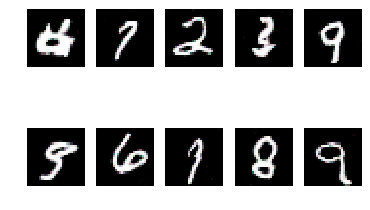

In [16]:
num_image = 10
for i in range(num_image):
    latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx).asnumpy()
    #label of "i : the index" class
    y_z_label = np.random.randint(i,i+1,1)

    y = np.zeros((1,28))
    y[np.arange(1),y_z_label] = 1
    y = y.reshape((1,28,1,1))

    latent_z = np.concatenate((latent_z,y) , axis = 1)
    latent_z = nd.array(latent_z, ctx = ctx)
    
    img = netG(latent_z)
    plt.subplot(2,5,i+1)
    visualize(img[0])
plt.show()

## End Model 1

## Model 2
( Convolution layers  and filters (you can't change one without other, since you eventually need to make a 28 x 28 image out of Generator and a single output out of Descriminator, without using Fully connected layers ) are messed with, Well this I had to since the input to convolution in the tutorial was (64 x 64), while we use (28 x 28) )

In [17]:
# build the generator
nc = 3
ngf = 28
netG = nn.Sequential()
with netG.name_scope():
    # input is Z, going into a convolution
    netG.add(nn.Conv2DTranspose(ngf * 8, 4, 1, 0, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 4 x 4
    netG.add(nn.Conv2DTranspose(ngf * 4, 4, 2, 0, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*4) x 10 x 10
    netG.add(nn.Conv2DTranspose(nc, 3, 3, 1, use_bias=False))
    netG.add(nn.Activation('tanh'))
    # state size. (nc) x 28 x 28

# build the discriminator
ndf = 28
netD = nn.Sequential()
with netD.name_scope():
    # input is (nc) x 29 x 28
    netD.add(nn.Conv2D(ndf, (4,3), 3, 1, use_bias=False))
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 10 x 10
    netD.add(nn.Conv2D(ndf * 2, 3, 3, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf*8) x 4 x 4
    netD.add(nn.Conv2D(1, 4, 1, 0, use_bias=False))
    #state size. (1) x 1 x 1

In [18]:
# loss
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

# initialize the generator and the discriminator
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})



In [19]:
'''
def img_label_data(data,label):   #for image and label combine, not z and label
    data = data.asnumpy()
    label_temp = nd.array(label).asnumpy().astype(int)
    label = np.zeros((batch_size,28))
    label[np.arange(batch_size),label_temp]=1
    label = label.reshape((batch_size,1,1,28))
    label = np.tile(label, (1,3, 1, 1))
    return nd.array(np.concatenate((data,label),axis = 2), ctx = ctx)
'''


'\ndef img_label_data(data,label):   #for image and label combine, not z and label\n    data = data.asnumpy()\n    label_temp = nd.array(label).asnumpy().astype(int)\n    label = np.zeros((batch_size,28))\n    label[np.arange(batch_size),label_temp]=1\n    label = label.reshape((batch_size,1,1,28))\n    label = np.tile(label, (1,3, 1, 1))\n    return nd.array(np.concatenate((data,label),axis = 2), ctx = ctx)\n'

In [20]:
def img_label_data_nd(data,label):   #for image and label combine, not z and label
    label_temp = nd.array(label).astype(int)
    label = nd.zeros((batch_size,28))
    label[nd.arange(batch_size).astype(int),label_temp]=1
    label = label.reshape((batch_size,1,1,28))
    label = nd.tile(label, (1,3, 1, 1))
    return nd.array(nd.concat(data,label ,dim = 2), ctx = ctx)

In [21]:
i=0
train_data.reset()
for batch in train_data:
    if(i == 0):
        i+=1
    else:
        break
    data = batch.data[0]
    label = batch.label[0]
    print(img_label_data_nd(data,label).shape)

(64, 3, 29, 28)


In [22]:
from datetime import datetime
import time
import logging
import numpy as np

real_label = nd.ones((batch_size,), ctx=ctx)
fake_label = nd.zeros((batch_size,),ctx=ctx)

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()
metric = mx.metric.CustomMetric(facc)

stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
logging.basicConfig(level=logging.DEBUG)

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    train_data.reset()
    iter = 0
    for batch in train_data:
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        data = nd.array(batch.data[0])
        mnist_label = nd.array(batch.label[0])
        
        latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1)).asnumpy()
        y_z_label = np.random.randint(0,10,batch_size)
        
        y = np.zeros((batch_size,28))
        y[np.arange(batch_size),y_z_label] = 1
        y = y.reshape((batch_size,28,1,1))
        
        latent_z = np.concatenate((latent_z,y),axis = 1)
        latent_z = nd.array(latent_z, ctx = ctx)

        with autograd.record():
            # train with real image
            G_data = img_label_data_nd(data,mnist_label)
            
            output = netD(G_data).reshape((-1, 1))
            errD_real = loss(output, real_label)
            metric.update([real_label,], [output,])

            # train with fake image
            fake = netG(latent_z)
            
            G_fake_data = img_label_data_nd(fake.detach(),y_z_label)
            
            output = netD(G_fake_data).reshape((-1, 1))
            errD_fake = loss(output, fake_label)
            errD = errD_real + errD_fake
            errD.backward()
            metric.update([fake_label,], [output,])

        trainerD.step(batch.data[0].shape[0])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        
        with autograd.record():
            # train with fake image
            fake = netG(latent_z)
            G_fake_data = img_label_data_nd(fake,y_z_label)
            
            output = netD(G_fake_data).reshape((-1, 1))
            errG = loss(output, real_label)
            errG.backward()

        trainerG.step(batch.data[0].shape[0])
        
        # Print log infomation every ten batches
        if iter % 10 == 0:
            name, acc = metric.get()
            logging.info('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
            logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d'
                     %(nd.mean(errD).asscalar(),
                       nd.mean(errG).asscalar(), acc, iter, epoch))
        iter = iter + 1
        btic = time.time()

    name, acc = metric.get()
    metric.reset()
    # logging.info('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
    # logging.info('time: %f' % (time.time() - tic))

    # Visualize one generated image for each epoch
    # fake_img = fake[0]
    # visualize(fake_img)
    # plt.show()

INFO:root:speed: 414.10334864161496 samples/s
INFO:root:discriminator loss = 1.367329, generator loss = 0.674170, binary training acc = 0.570312 at iter 0 epoch 0
INFO:root:speed: 374.98946144991675 samples/s
INFO:root:discriminator loss = 1.598974, generator loss = 0.354327, binary training acc = 0.500000 at iter 10 epoch 0
INFO:root:speed: 349.3229261690817 samples/s
INFO:root:discriminator loss = 1.435291, generator loss = 0.436919, binary training acc = 0.501860 at iter 20 epoch 0
INFO:root:speed: 374.366604884811 samples/s
INFO:root:discriminator loss = 1.535686, generator loss = 0.420857, binary training acc = 0.502772 at iter 30 epoch 0
INFO:root:speed: 287.07218205928905 samples/s
INFO:root:discriminator loss = 1.491409, generator loss = 0.490255, binary training acc = 0.493712 at iter 40 epoch 0
INFO:root:speed: 369.87113539849594 samples/s
INFO:root:discriminator loss = 1.326992, generator loss = 0.582616, binary training acc = 0.517157 at iter 50 epoch 0
INFO:root:speed: 371

INFO:root:speed: 372.4809253624063 samples/s
INFO:root:discriminator loss = 0.871666, generator loss = 0.773125, binary training acc = 0.860872 at iter 500 epoch 0
INFO:root:speed: 372.78094235573656 samples/s
INFO:root:discriminator loss = 0.865327, generator loss = 1.127066, binary training acc = 0.860231 at iter 510 epoch 0
INFO:root:speed: 325.98441941998465 samples/s
INFO:root:discriminator loss = 0.908474, generator loss = 1.395024, binary training acc = 0.860305 at iter 520 epoch 0
INFO:root:speed: 356.9743847526643 samples/s
INFO:root:discriminator loss = 0.897238, generator loss = 1.546256, binary training acc = 0.859493 at iter 530 epoch 0
INFO:root:speed: 364.6467794694574 samples/s
INFO:root:discriminator loss = 0.833014, generator loss = 1.205030, binary training acc = 0.858667 at iter 540 epoch 0
INFO:root:speed: 375.9426469084762 samples/s
INFO:root:discriminator loss = 0.873456, generator loss = 1.168167, binary training acc = 0.858581 at iter 550 epoch 0
INFO:root:spee

INFO:root:speed: 373.8795971436252 samples/s
INFO:root:discriminator loss = 0.905433, generator loss = 1.042240, binary training acc = 0.805584 at iter 60 epoch 1
INFO:root:speed: 370.4601932100469 samples/s
INFO:root:discriminator loss = 0.903827, generator loss = 1.353650, binary training acc = 0.809969 at iter 70 epoch 1
INFO:root:speed: 371.9075840283743 samples/s
INFO:root:discriminator loss = 0.848707, generator loss = 1.187812, binary training acc = 0.809896 at iter 80 epoch 1
INFO:root:speed: 372.00654112873275 samples/s
INFO:root:discriminator loss = 0.911845, generator loss = 1.253503, binary training acc = 0.808637 at iter 90 epoch 1
INFO:root:speed: 366.78876222410787 samples/s
INFO:root:discriminator loss = 0.886879, generator loss = 1.020201, binary training acc = 0.810566 at iter 100 epoch 1
INFO:root:speed: 369.17526357337556 samples/s
INFO:root:discriminator loss = 0.949083, generator loss = 1.508319, binary training acc = 0.811655 at iter 110 epoch 1
INFO:root:speed: 

INFO:root:speed: 374.59281111238255 samples/s
INFO:root:discriminator loss = 0.748052, generator loss = 1.191796, binary training acc = 0.814032 at iter 560 epoch 1
INFO:root:speed: 376.746758286562 samples/s
INFO:root:discriminator loss = 0.863054, generator loss = 1.446869, binary training acc = 0.814552 at iter 570 epoch 1
INFO:root:speed: 372.8627549029004 samples/s
INFO:root:discriminator loss = 0.869790, generator loss = 0.725326, binary training acc = 0.814651 at iter 580 epoch 1
INFO:root:speed: 377.27095973543925 samples/s
INFO:root:discriminator loss = 0.920054, generator loss = 1.053359, binary training acc = 0.814113 at iter 590 epoch 1
INFO:root:speed: 360.4166747226071 samples/s
INFO:root:discriminator loss = 0.818795, generator loss = 1.192194, binary training acc = 0.814372 at iter 600 epoch 1
INFO:root:speed: 367.2539436276723 samples/s
INFO:root:discriminator loss = 0.873854, generator loss = 1.828660, binary training acc = 0.814699 at iter 610 epoch 1
INFO:root:speed

INFO:root:speed: 367.1213446573394 samples/s
INFO:root:discriminator loss = 0.783869, generator loss = 0.922877, binary training acc = 0.818246 at iter 120 epoch 2
INFO:root:speed: 360.5711100335405 samples/s
INFO:root:discriminator loss = 0.837641, generator loss = 0.935216, binary training acc = 0.815899 at iter 130 epoch 2
INFO:root:speed: 360.3431345174939 samples/s
INFO:root:discriminator loss = 0.868727, generator loss = 0.886633, binary training acc = 0.815935 at iter 140 epoch 2
INFO:root:speed: 363.15155516292987 samples/s
INFO:root:discriminator loss = 0.923871, generator loss = 0.782269, binary training acc = 0.813949 at iter 150 epoch 2
INFO:root:speed: 367.8704784562444 samples/s
INFO:root:discriminator loss = 0.920404, generator loss = 1.008794, binary training acc = 0.814587 at iter 160 epoch 2
INFO:root:speed: 362.7001322788855 samples/s
INFO:root:discriminator loss = 0.949965, generator loss = 0.839006, binary training acc = 0.813368 at iter 170 epoch 2
INFO:root:speed

INFO:root:speed: 365.70242783984787 samples/s
INFO:root:discriminator loss = 0.991328, generator loss = 0.995380, binary training acc = 0.804851 at iter 620 epoch 2
INFO:root:speed: 364.1639660954407 samples/s
INFO:root:discriminator loss = 0.872982, generator loss = 1.079809, binary training acc = 0.804997 at iter 630 epoch 2
INFO:root:speed: 363.27343541718824 samples/s
INFO:root:discriminator loss = 0.874924, generator loss = 1.233091, binary training acc = 0.805212 at iter 640 epoch 2
INFO:root:speed: 343.746982366726 samples/s
INFO:root:discriminator loss = 1.057139, generator loss = 0.762938, binary training acc = 0.804844 at iter 650 epoch 2
INFO:root:speed: 362.0236336222127 samples/s
INFO:root:discriminator loss = 0.985454, generator loss = 0.926597, binary training acc = 0.804770 at iter 660 epoch 2
INFO:root:speed: 363.0955569953618 samples/s
INFO:root:discriminator loss = 0.936575, generator loss = 1.636060, binary training acc = 0.804699 at iter 670 epoch 2
INFO:root:speed

INFO:root:speed: 366.4662872339409 samples/s
INFO:root:discriminator loss = 0.857752, generator loss = 1.089190, binary training acc = 0.785653 at iter 180 epoch 3
INFO:root:speed: 365.3400875121639 samples/s
INFO:root:discriminator loss = 0.958741, generator loss = 1.226442, binary training acc = 0.784440 at iter 190 epoch 3
INFO:root:speed: 363.1255187788473 samples/s
INFO:root:discriminator loss = 0.940308, generator loss = 1.421466, binary training acc = 0.779618 at iter 200 epoch 3
INFO:root:speed: 363.03761216637474 samples/s
INFO:root:discriminator loss = 0.959825, generator loss = 1.427436, binary training acc = 0.779362 at iter 210 epoch 3
INFO:root:speed: 363.8663089933865 samples/s
INFO:root:discriminator loss = 0.836183, generator loss = 1.496039, binary training acc = 0.778988 at iter 220 epoch 3
INFO:root:speed: 364.60715643981786 samples/s
INFO:root:discriminator loss = 0.992790, generator loss = 0.800452, binary training acc = 0.779660 at iter 230 epoch 3
INFO:root:spee

INFO:root:speed: 364.25044202276126 samples/s
INFO:root:discriminator loss = 0.965891, generator loss = 1.008543, binary training acc = 0.775342 at iter 680 epoch 3
INFO:root:speed: 362.5727595787472 samples/s
INFO:root:discriminator loss = 1.020610, generator loss = 0.885945, binary training acc = 0.775303 at iter 690 epoch 3
INFO:root:speed: 359.69563370562184 samples/s
INFO:root:discriminator loss = 0.945292, generator loss = 0.900364, binary training acc = 0.774831 at iter 700 epoch 3
INFO:root:speed: 362.23223252129725 samples/s
INFO:root:discriminator loss = 1.000583, generator loss = 1.232911, binary training acc = 0.774558 at iter 710 epoch 3
INFO:root:speed: 363.66863379449745 samples/s
INFO:root:discriminator loss = 1.198010, generator loss = 0.610257, binary training acc = 0.774250 at iter 720 epoch 3
INFO:root:speed: 364.11407581633387 samples/s
INFO:root:discriminator loss = 1.008733, generator loss = 1.102306, binary training acc = 0.774025 at iter 730 epoch 3
INFO:root:s

INFO:root:speed: 358.28177729135245 samples/s
INFO:root:discriminator loss = 0.901757, generator loss = 1.235372, binary training acc = 0.761314 at iter 240 epoch 4
INFO:root:speed: 361.2664944013781 samples/s
INFO:root:discriminator loss = 0.996714, generator loss = 0.625393, binary training acc = 0.759805 at iter 250 epoch 4
INFO:root:speed: 364.0039704279058 samples/s
INFO:root:discriminator loss = 0.832901, generator loss = 1.283344, binary training acc = 0.760147 at iter 260 epoch 4
INFO:root:speed: 361.39392389112226 samples/s
INFO:root:discriminator loss = 1.006566, generator loss = 0.891732, binary training acc = 0.760407 at iter 270 epoch 4
INFO:root:speed: 362.2341877458488 samples/s
INFO:root:discriminator loss = 0.917683, generator loss = 1.263290, binary training acc = 0.760482 at iter 280 epoch 4
INFO:root:speed: 361.2519089722368 samples/s
INFO:root:discriminator loss = 1.005815, generator loss = 1.449378, binary training acc = 0.762242 at iter 290 epoch 4
INFO:root:spee

INFO:root:speed: 363.8776534889143 samples/s
INFO:root:discriminator loss = 0.938069, generator loss = 1.259130, binary training acc = 0.759014 at iter 740 epoch 4
INFO:root:speed: 361.78650407293 samples/s
INFO:root:discriminator loss = 1.053973, generator loss = 1.050277, binary training acc = 0.758936 at iter 750 epoch 4
INFO:root:speed: 357.7670183444665 samples/s
INFO:root:discriminator loss = 1.057872, generator loss = 1.552604, binary training acc = 0.758726 at iter 760 epoch 4
INFO:root:speed: 361.0522071175995 samples/s
INFO:root:discriminator loss = 0.988074, generator loss = 1.093510, binary training acc = 0.758623 at iter 770 epoch 4
INFO:root:speed: 359.2176619678353 samples/s
INFO:root:discriminator loss = 0.984937, generator loss = 0.832244, binary training acc = 0.758563 at iter 780 epoch 4
INFO:root:speed: 363.3565377941053 samples/s
INFO:root:discriminator loss = 0.937460, generator loss = 1.528248, binary training acc = 0.758385 at iter 790 epoch 4
INFO:root:speed: 3

INFO:root:speed: 364.5497183396981 samples/s
INFO:root:discriminator loss = 1.031886, generator loss = 0.924772, binary training acc = 0.751739 at iter 300 epoch 5
INFO:root:speed: 363.6499126217538 samples/s
INFO:root:discriminator loss = 1.003132, generator loss = 1.144035, binary training acc = 0.750879 at iter 310 epoch 5
INFO:root:speed: 363.0724750589712 samples/s
INFO:root:discriminator loss = 0.959509, generator loss = 1.134398, binary training acc = 0.751290 at iter 320 epoch 5
INFO:root:speed: 365.13534475840186 samples/s
INFO:root:discriminator loss = 0.870336, generator loss = 1.116523, binary training acc = 0.752148 at iter 330 epoch 5
INFO:root:speed: 314.08192430502174 samples/s
INFO:root:discriminator loss = 0.923804, generator loss = 1.218116, binary training acc = 0.751993 at iter 340 epoch 5
INFO:root:speed: 332.1423519600492 samples/s
INFO:root:discriminator loss = 0.989133, generator loss = 1.220656, binary training acc = 0.751580 at iter 350 epoch 5
INFO:root:spee

INFO:root:speed: 368.34750725894537 samples/s
INFO:root:discriminator loss = 1.182769, generator loss = 1.558957, binary training acc = 0.749132 at iter 800 epoch 5
INFO:root:speed: 350.71997324218955 samples/s
INFO:root:discriminator loss = 1.091956, generator loss = 0.799936, binary training acc = 0.749114 at iter 810 epoch 5
INFO:root:speed: 365.7497642833396 samples/s
INFO:root:discriminator loss = 0.985128, generator loss = 1.141815, binary training acc = 0.749343 at iter 820 epoch 5
INFO:root:speed: 359.8335332889186 samples/s
INFO:root:discriminator loss = 0.989362, generator loss = 1.283862, binary training acc = 0.749445 at iter 830 epoch 5
INFO:root:speed: 364.555659372895 samples/s
INFO:root:discriminator loss = 0.931490, generator loss = 1.115744, binary training acc = 0.749201 at iter 840 epoch 5
INFO:root:speed: 365.46742201146634 samples/s
INFO:root:discriminator loss = 1.110910, generator loss = 0.636111, binary training acc = 0.749146 at iter 850 epoch 5
INFO:root:spee

INFO:root:speed: 324.0549516879053 samples/s
INFO:root:discriminator loss = 1.062041, generator loss = 0.954192, binary training acc = 0.742837 at iter 360 epoch 6
INFO:root:speed: 367.56321074172513 samples/s
INFO:root:discriminator loss = 0.992732, generator loss = 1.311071, binary training acc = 0.742925 at iter 370 epoch 6
INFO:root:speed: 365.2451418199432 samples/s
INFO:root:discriminator loss = 1.007227, generator loss = 1.237419, binary training acc = 0.742659 at iter 380 epoch 6
INFO:root:speed: 363.6114909894778 samples/s
INFO:root:discriminator loss = 0.954330, generator loss = 1.387776, binary training acc = 0.741428 at iter 390 epoch 6
INFO:root:speed: 349.08307053693693 samples/s
INFO:root:discriminator loss = 1.032960, generator loss = 1.284859, binary training acc = 0.741252 at iter 400 epoch 6
INFO:root:speed: 354.41375112720107 samples/s
INFO:root:discriminator loss = 0.910939, generator loss = 1.419809, binary training acc = 0.741902 at iter 410 epoch 6
INFO:root:spe

INFO:root:speed: 366.47078996515984 samples/s
INFO:root:discriminator loss = 1.050795, generator loss = 1.427660, binary training acc = 0.741734 at iter 860 epoch 6
INFO:root:speed: 366.4117629394245 samples/s
INFO:root:discriminator loss = 1.049661, generator loss = 0.808317, binary training acc = 0.741721 at iter 870 epoch 6
INFO:root:speed: 360.26092114763645 samples/s
INFO:root:discriminator loss = 1.047652, generator loss = 1.611320, binary training acc = 0.741726 at iter 880 epoch 6
INFO:root:speed: 361.4980742400655 samples/s
INFO:root:discriminator loss = 1.145825, generator loss = 1.155630, binary training acc = 0.741504 at iter 890 epoch 6
INFO:root:speed: 367.79386534000685 samples/s
INFO:root:discriminator loss = 1.065532, generator loss = 1.184162, binary training acc = 0.741355 at iter 900 epoch 6
INFO:root:speed: 367.1680447327783 samples/s
INFO:root:discriminator loss = 0.969092, generator loss = 0.810236, binary training acc = 0.741536 at iter 910 epoch 6
INFO:root:spe

INFO:root:speed: 365.96617305023324 samples/s
INFO:root:discriminator loss = 0.950622, generator loss = 0.936772, binary training acc = 0.735878 at iter 420 epoch 7
INFO:root:speed: 363.5420570999839 samples/s
INFO:root:discriminator loss = 1.378023, generator loss = 1.623615, binary training acc = 0.735408 at iter 430 epoch 7
INFO:root:speed: 359.64792385688867 samples/s
INFO:root:discriminator loss = 1.155629, generator loss = 1.017945, binary training acc = 0.734836 at iter 440 epoch 7
INFO:root:speed: 366.6840458868238 samples/s
INFO:root:discriminator loss = 0.877499, generator loss = 1.475435, binary training acc = 0.735155 at iter 450 epoch 7
INFO:root:speed: 364.63390104023756 samples/s
INFO:root:discriminator loss = 1.072239, generator loss = 1.050459, binary training acc = 0.735341 at iter 460 epoch 7
INFO:root:speed: 365.88336895363545 samples/s
INFO:root:discriminator loss = 1.214112, generator loss = 1.248617, binary training acc = 0.735105 at iter 470 epoch 7
INFO:root:sp

INFO:root:speed: 345.0863900426673 samples/s
INFO:root:discriminator loss = 0.963595, generator loss = 1.177179, binary training acc = 0.733399 at iter 920 epoch 7
INFO:root:speed: 361.41776610311433 samples/s
INFO:root:discriminator loss = 0.972156, generator loss = 1.109891, binary training acc = 0.733670 at iter 930 epoch 7
INFO:root:speed: 362.07197590462204 samples/s
INFO:root:discriminator loss = 0.989918, generator loss = 1.190795, binary training acc = 0.648438 at iter 0 epoch 8
INFO:root:speed: 364.11259413590295 samples/s
INFO:root:discriminator loss = 0.945470, generator loss = 1.098533, binary training acc = 0.719460 at iter 10 epoch 8
INFO:root:speed: 362.7476750188512 samples/s
INFO:root:discriminator loss = 1.109230, generator loss = 0.834307, binary training acc = 0.728423 at iter 20 epoch 8
INFO:root:speed: 361.82502867664203 samples/s
INFO:root:discriminator loss = 1.096279, generator loss = 1.196200, binary training acc = 0.729083 at iter 30 epoch 8
INFO:root:speed: 

INFO:root:speed: 358.2277488413183 samples/s
INFO:root:discriminator loss = 0.924799, generator loss = 1.143825, binary training acc = 0.726124 at iter 480 epoch 8
INFO:root:speed: 363.3594888732471 samples/s
INFO:root:discriminator loss = 1.014923, generator loss = 1.419700, binary training acc = 0.726276 at iter 490 epoch 8
INFO:root:speed: 361.34916741825623 samples/s
INFO:root:discriminator loss = 0.879503, generator loss = 1.073321, binary training acc = 0.726032 at iter 500 epoch 8
INFO:root:speed: 361.3851663175354 samples/s
INFO:root:discriminator loss = 1.129393, generator loss = 1.147518, binary training acc = 0.725538 at iter 510 epoch 8
INFO:root:speed: 362.35300724070345 samples/s
INFO:root:discriminator loss = 1.212891, generator loss = 0.776244, binary training acc = 0.725918 at iter 520 epoch 8
INFO:root:speed: 356.4628996896633 samples/s
INFO:root:discriminator loss = 1.089391, generator loss = 1.056097, binary training acc = 0.726136 at iter 530 epoch 8
INFO:root:spee

INFO:root:speed: 360.7930700321902 samples/s
INFO:root:discriminator loss = 0.916219, generator loss = 1.276160, binary training acc = 0.726372 at iter 40 epoch 9
INFO:root:speed: 362.4376464107345 samples/s
INFO:root:discriminator loss = 1.111300, generator loss = 0.921889, binary training acc = 0.729626 at iter 50 epoch 9
INFO:root:speed: 364.3671260470438 samples/s
INFO:root:discriminator loss = 1.046328, generator loss = 0.975275, binary training acc = 0.732966 at iter 60 epoch 9
INFO:root:speed: 359.342206824726 samples/s
INFO:root:discriminator loss = 1.204579, generator loss = 1.126594, binary training acc = 0.734815 at iter 70 epoch 9
INFO:root:speed: 361.0454085098084 samples/s
INFO:root:discriminator loss = 1.155807, generator loss = 0.913972, binary training acc = 0.732928 at iter 80 epoch 9
INFO:root:speed: 356.6310206749586 samples/s
INFO:root:discriminator loss = 1.085406, generator loss = 0.968774, binary training acc = 0.730941 at iter 90 epoch 9
INFO:root:speed: 366.25

INFO:root:speed: 365.5261451480907 samples/s
INFO:root:discriminator loss = 1.014584, generator loss = 1.422435, binary training acc = 0.722028 at iter 540 epoch 9
INFO:root:speed: 364.8509745290456 samples/s
INFO:root:discriminator loss = 1.008972, generator loss = 1.294486, binary training acc = 0.722181 at iter 550 epoch 9
INFO:root:speed: 360.21016103990905 samples/s
INFO:root:discriminator loss = 1.004742, generator loss = 1.179502, binary training acc = 0.722594 at iter 560 epoch 9
INFO:root:speed: 364.0395128698907 samples/s
INFO:root:discriminator loss = 1.012250, generator loss = 1.218892, binary training acc = 0.723279 at iter 570 epoch 9
INFO:root:speed: 360.66024890869005 samples/s
INFO:root:discriminator loss = 1.069976, generator loss = 1.195382, binary training acc = 0.723671 at iter 580 epoch 9
INFO:root:speed: 367.83569617824793 samples/s
INFO:root:discriminator loss = 1.111694, generator loss = 0.819843, binary training acc = 0.723033 at iter 590 epoch 9
INFO:root:spe

INFO:root:speed: 365.90182204308184 samples/s
INFO:root:discriminator loss = 0.939542, generator loss = 1.074618, binary training acc = 0.725712 at iter 100 epoch 10
INFO:root:speed: 358.81720384113606 samples/s
INFO:root:discriminator loss = 1.080852, generator loss = 1.569076, binary training acc = 0.727337 at iter 110 epoch 10
INFO:root:speed: 364.95266166803754 samples/s
INFO:root:discriminator loss = 0.968465, generator loss = 1.018892, binary training acc = 0.727144 at iter 120 epoch 10
INFO:root:speed: 366.5853966970703 samples/s
INFO:root:discriminator loss = 1.082853, generator loss = 1.372224, binary training acc = 0.729783 at iter 130 epoch 10
INFO:root:speed: 361.1702523283255 samples/s
INFO:root:discriminator loss = 0.953395, generator loss = 1.066271, binary training acc = 0.728059 at iter 140 epoch 10
INFO:root:speed: 364.9888858975719 samples/s
INFO:root:discriminator loss = 1.230118, generator loss = 1.826568, binary training acc = 0.727701 at iter 150 epoch 10
INFO:ro

INFO:root:speed: 362.65309193878943 samples/s
INFO:root:discriminator loss = 1.136642, generator loss = 1.344581, binary training acc = 0.725406 at iter 600 epoch 10
INFO:root:speed: 364.0716057587327 samples/s
INFO:root:discriminator loss = 1.003450, generator loss = 1.516072, binary training acc = 0.725143 at iter 610 epoch 10
INFO:root:speed: 348.10616613778984 samples/s
INFO:root:discriminator loss = 1.028859, generator loss = 1.076016, binary training acc = 0.724990 at iter 620 epoch 10
INFO:root:speed: 354.6314724245715 samples/s
INFO:root:discriminator loss = 0.959091, generator loss = 0.962522, binary training acc = 0.724941 at iter 630 epoch 10
INFO:root:speed: 338.2626834901981 samples/s
INFO:root:discriminator loss = 0.998383, generator loss = 1.384590, binary training acc = 0.725039 at iter 640 epoch 10
INFO:root:speed: 362.67906061777 samples/s
INFO:root:discriminator loss = 1.103925, generator loss = 0.987660, binary training acc = 0.724822 at iter 650 epoch 10
INFO:root:

INFO:root:speed: 317.4065211093572 samples/s
INFO:root:discriminator loss = 0.967139, generator loss = 1.280493, binary training acc = 0.713898 at iter 160 epoch 11
INFO:root:speed: 362.31534818306113 samples/s
INFO:root:discriminator loss = 1.152813, generator loss = 0.925321, binary training acc = 0.712811 at iter 170 epoch 11
INFO:root:speed: 360.7096818407201 samples/s
INFO:root:discriminator loss = 1.092124, generator loss = 0.744690, binary training acc = 0.711801 at iter 180 epoch 11
INFO:root:speed: 359.9705732082632 samples/s
INFO:root:discriminator loss = 1.008155, generator loss = 1.178977, binary training acc = 0.713064 at iter 190 epoch 11
INFO:root:speed: 344.8328231320918 samples/s
INFO:root:discriminator loss = 1.110005, generator loss = 1.105478, binary training acc = 0.712725 at iter 200 epoch 11
INFO:root:speed: 321.16457749823826 samples/s
INFO:root:discriminator loss = 0.989482, generator loss = 1.417698, binary training acc = 0.712307 at iter 210 epoch 11
INFO:roo

INFO:root:speed: 342.81893786141933 samples/s
INFO:root:discriminator loss = 1.045163, generator loss = 1.267663, binary training acc = 0.715831 at iter 660 epoch 11
INFO:root:speed: 363.25524647753906 samples/s
INFO:root:discriminator loss = 1.011650, generator loss = 1.284749, binary training acc = 0.715606 at iter 670 epoch 11
INFO:root:speed: 364.5630859367042 samples/s
INFO:root:discriminator loss = 1.110685, generator loss = 1.110492, binary training acc = 0.715664 at iter 680 epoch 11
INFO:root:speed: 364.6279574566348 samples/s
INFO:root:discriminator loss = 1.300937, generator loss = 0.742517, binary training acc = 0.715415 at iter 690 epoch 11
INFO:root:speed: 328.86386172880646 samples/s
INFO:root:discriminator loss = 0.875940, generator loss = 1.232027, binary training acc = 0.715574 at iter 700 epoch 11
INFO:root:speed: 363.9718894615311 samples/s
INFO:root:discriminator loss = 1.073584, generator loss = 1.277542, binary training acc = 0.715849 at iter 710 epoch 11
INFO:ro

INFO:root:speed: 358.3076019520113 samples/s
INFO:root:discriminator loss = 0.821939, generator loss = 1.404108, binary training acc = 0.715887 at iter 220 epoch 12
INFO:root:speed: 365.74278761652766 samples/s
INFO:root:discriminator loss = 0.967654, generator loss = 1.139083, binary training acc = 0.715943 at iter 230 epoch 12
INFO:root:speed: 361.03861015804785 samples/s
INFO:root:discriminator loss = 0.944029, generator loss = 1.161623, binary training acc = 0.717162 at iter 240 epoch 12
INFO:root:speed: 364.60170894663855 samples/s
INFO:root:discriminator loss = 1.098116, generator loss = 0.841224, binary training acc = 0.718470 at iter 250 epoch 12
INFO:root:speed: 365.0836983914774 samples/s
INFO:root:discriminator loss = 1.055956, generator loss = 1.228555, binary training acc = 0.718840 at iter 260 epoch 12
INFO:root:speed: 365.76022978263035 samples/s
INFO:root:discriminator loss = 1.110801, generator loss = 1.459564, binary training acc = 0.719874 at iter 270 epoch 12
INFO:r

INFO:root:speed: 365.8040917223908 samples/s
INFO:root:discriminator loss = 1.206134, generator loss = 1.355631, binary training acc = 0.720560 at iter 720 epoch 12
INFO:root:speed: 362.3065458957737 samples/s
INFO:root:discriminator loss = 0.867723, generator loss = 1.208641, binary training acc = 0.720813 at iter 730 epoch 12
INFO:root:speed: 356.4297677802962 samples/s
INFO:root:discriminator loss = 0.963082, generator loss = 0.964028, binary training acc = 0.720353 at iter 740 epoch 12
INFO:root:speed: 365.36644244877516 samples/s
INFO:root:discriminator loss = 1.025806, generator loss = 1.218859, binary training acc = 0.720560 at iter 750 epoch 12
INFO:root:speed: 363.18742271109846 samples/s
INFO:root:discriminator loss = 1.002879, generator loss = 0.957821, binary training acc = 0.720618 at iter 760 epoch 12
INFO:root:speed: 365.6546055633729 samples/s
INFO:root:discriminator loss = 1.180269, generator loss = 0.849461, binary training acc = 0.720462 at iter 770 epoch 12
INFO:roo

INFO:root:speed: 362.3916525927696 samples/s
INFO:root:discriminator loss = 1.129452, generator loss = 1.410671, binary training acc = 0.713634 at iter 280 epoch 13
INFO:root:speed: 362.3148591558801 samples/s
INFO:root:discriminator loss = 0.986957, generator loss = 1.268387, binary training acc = 0.714562 at iter 290 epoch 13
INFO:root:speed: 281.931813861357 samples/s
INFO:root:discriminator loss = 1.238947, generator loss = 0.582193, binary training acc = 0.714545 at iter 300 epoch 13
INFO:root:speed: 363.5637215664764 samples/s
INFO:root:discriminator loss = 0.998628, generator loss = 0.963346, binary training acc = 0.714027 at iter 310 epoch 13
INFO:root:speed: 361.13672547144046 samples/s
INFO:root:discriminator loss = 1.038771, generator loss = 1.079190, binary training acc = 0.714418 at iter 320 epoch 13
INFO:root:speed: 305.3362588964075 samples/s
INFO:root:discriminator loss = 0.961236, generator loss = 1.292984, binary training acc = 0.714926 at iter 330 epoch 13
INFO:root:

INFO:root:speed: 370.4320759533847 samples/s
INFO:root:discriminator loss = 0.948872, generator loss = 0.956439, binary training acc = 0.714089 at iter 780 epoch 13
INFO:root:speed: 371.01215443345194 samples/s
INFO:root:discriminator loss = 1.093858, generator loss = 1.345418, binary training acc = 0.714246 at iter 790 epoch 13
INFO:root:speed: 369.0174297839114 samples/s
INFO:root:discriminator loss = 1.110993, generator loss = 1.094341, binary training acc = 0.714000 at iter 800 epoch 13
INFO:root:speed: 369.6964124627977 samples/s
INFO:root:discriminator loss = 1.108769, generator loss = 0.930309, binary training acc = 0.714328 at iter 810 epoch 13
INFO:root:speed: 370.5374098107665 samples/s
INFO:root:discriminator loss = 1.142897, generator loss = 0.831937, binary training acc = 0.714373 at iter 820 epoch 13
INFO:root:speed: 370.829180014892 samples/s
INFO:root:discriminator loss = 0.988397, generator loss = 1.075675, binary training acc = 0.714463 at iter 830 epoch 13
INFO:root:

INFO:root:speed: 366.4752928070293 samples/s
INFO:root:discriminator loss = 0.983790, generator loss = 1.092491, binary training acc = 0.709402 at iter 340 epoch 14
INFO:root:speed: 365.566963866218 samples/s
INFO:root:discriminator loss = 1.022597, generator loss = 1.265258, binary training acc = 0.709980 at iter 350 epoch 14
INFO:root:speed: 360.442324089379 samples/s
INFO:root:discriminator loss = 1.227831, generator loss = 0.895554, binary training acc = 0.709726 at iter 360 epoch 14
INFO:root:speed: 364.72852917239027 samples/s
INFO:root:discriminator loss = 0.981401, generator loss = 1.677783, binary training acc = 0.710622 at iter 370 epoch 14
INFO:root:speed: 367.3363639598118 samples/s
INFO:root:discriminator loss = 1.074743, generator loss = 1.435727, binary training acc = 0.710671 at iter 380 epoch 14
INFO:root:speed: 364.2702137158661 samples/s
INFO:root:discriminator loss = 1.065151, generator loss = 1.355448, binary training acc = 0.711117 at iter 390 epoch 14
INFO:root:s

INFO:root:speed: 361.281081008331 samples/s
INFO:root:discriminator loss = 1.025550, generator loss = 1.413220, binary training acc = 0.709693 at iter 840 epoch 14
INFO:root:speed: 362.62614724135227 samples/s
INFO:root:discriminator loss = 1.070621, generator loss = 0.974157, binary training acc = 0.709496 at iter 850 epoch 14
INFO:root:speed: 361.1168066639044 samples/s
INFO:root:discriminator loss = 1.215935, generator loss = 1.543565, binary training acc = 0.709640 at iter 860 epoch 14
INFO:root:speed: 365.3336236744115 samples/s
INFO:root:discriminator loss = 1.223485, generator loss = 0.841028, binary training acc = 0.709807 at iter 870 epoch 14
INFO:root:speed: 362.7716961931572 samples/s
INFO:root:discriminator loss = 0.884985, generator loss = 1.223965, binary training acc = 0.710104 at iter 880 epoch 14
INFO:root:speed: 364.05481800341494 samples/s
INFO:root:discriminator loss = 1.101167, generator loss = 1.140244, binary training acc = 0.710017 at iter 890 epoch 14
INFO:root

INFO:root:speed: 363.64301583345076 samples/s
INFO:root:discriminator loss = 1.139040, generator loss = 1.642051, binary training acc = 0.712087 at iter 400 epoch 15
INFO:root:speed: 362.9070585833623 samples/s
INFO:root:discriminator loss = 1.080195, generator loss = 1.271821, binary training acc = 0.712021 at iter 410 epoch 15
INFO:root:speed: 366.83537771947084 samples/s
INFO:root:discriminator loss = 0.931306, generator loss = 1.319914, binary training acc = 0.712088 at iter 420 epoch 15
INFO:root:speed: 364.24401668462315 samples/s
INFO:root:discriminator loss = 1.020896, generator loss = 1.382409, binary training acc = 0.712206 at iter 430 epoch 15
INFO:root:speed: 363.642030599334 samples/s
INFO:root:discriminator loss = 0.981839, generator loss = 1.072398, binary training acc = 0.711770 at iter 440 epoch 15
INFO:root:speed: 360.8706750643607 samples/s
INFO:root:discriminator loss = 1.185669, generator loss = 1.872012, binary training acc = 0.711180 at iter 450 epoch 15
INFO:roo

INFO:root:speed: 360.3489392320373 samples/s
INFO:root:discriminator loss = 1.075323, generator loss = 1.166034, binary training acc = 0.708987 at iter 900 epoch 15
INFO:root:speed: 366.63947191221484 samples/s
INFO:root:discriminator loss = 1.086559, generator loss = 1.004040, binary training acc = 0.709282 at iter 910 epoch 15
INFO:root:speed: 369.5035431315006 samples/s
INFO:root:discriminator loss = 1.130424, generator loss = 0.793387, binary training acc = 0.709419 at iter 920 epoch 15
INFO:root:speed: 356.2055793746525 samples/s
INFO:root:discriminator loss = 1.041501, generator loss = 1.417229, binary training acc = 0.709528 at iter 930 epoch 15
INFO:root:speed: 363.2090449296815 samples/s
INFO:root:discriminator loss = 1.024059, generator loss = 1.493172, binary training acc = 0.710938 at iter 0 epoch 16
INFO:root:speed: 356.617280899981 samples/s
INFO:root:discriminator loss = 1.086499, generator loss = 1.123606, binary training acc = 0.681818 at iter 10 epoch 16
INFO:root:spe

INFO:root:speed: 362.68543086175055 samples/s
INFO:root:discriminator loss = 1.165168, generator loss = 0.790761, binary training acc = 0.705582 at iter 460 epoch 16
INFO:root:speed: 361.92991567769303 samples/s
INFO:root:discriminator loss = 1.244930, generator loss = 0.799178, binary training acc = 0.705447 at iter 470 epoch 16
INFO:root:speed: 364.56853227580774 samples/s
INFO:root:discriminator loss = 1.066660, generator loss = 1.286633, binary training acc = 0.705236 at iter 480 epoch 16
INFO:root:speed: 349.7338986009886 samples/s
INFO:root:discriminator loss = 1.051452, generator loss = 1.083892, binary training acc = 0.705337 at iter 490 epoch 16
INFO:root:speed: 347.50005954877565 samples/s
INFO:root:discriminator loss = 0.876611, generator loss = 1.269541, binary training acc = 0.705215 at iter 500 epoch 16
INFO:root:speed: 360.99782542331627 samples/s
INFO:root:discriminator loss = 1.067198, generator loss = 1.182871, binary training acc = 0.704700 at iter 510 epoch 16
INFO:

INFO:root:speed: 356.95824512505186 samples/s
INFO:root:discriminator loss = 0.976175, generator loss = 1.492780, binary training acc = 0.689732 at iter 20 epoch 17
INFO:root:speed: 367.27404273717104 samples/s
INFO:root:discriminator loss = 1.016755, generator loss = 1.411986, binary training acc = 0.686744 at iter 30 epoch 17
INFO:root:speed: 365.3465515786494 samples/s
INFO:root:discriminator loss = 1.266839, generator loss = 1.844812, binary training acc = 0.683117 at iter 40 epoch 17
INFO:root:speed: 358.03280822566427 samples/s
INFO:root:discriminator loss = 1.036392, generator loss = 1.062185, binary training acc = 0.687806 at iter 50 epoch 17
INFO:root:speed: 364.87973880018814 samples/s
INFO:root:discriminator loss = 1.111961, generator loss = 1.119705, binary training acc = 0.694416 at iter 60 epoch 17
INFO:root:speed: 366.10792483504133 samples/s
INFO:root:discriminator loss = 1.096244, generator loss = 1.177337, binary training acc = 0.695423 at iter 70 epoch 17
INFO:root:s

INFO:root:speed: 365.0568877707136 samples/s
INFO:root:discriminator loss = 1.285077, generator loss = 0.589987, binary training acc = 0.701655 at iter 520 epoch 17
INFO:root:speed: 363.97978579012096 samples/s
INFO:root:discriminator loss = 1.014032, generator loss = 1.030363, binary training acc = 0.701095 at iter 530 epoch 17
INFO:root:speed: 357.15059146916656 samples/s
INFO:root:discriminator loss = 1.025540, generator loss = 1.239410, binary training acc = 0.701060 at iter 540 epoch 17
INFO:root:speed: 340.54393058083997 samples/s
INFO:root:discriminator loss = 1.149542, generator loss = 0.873796, binary training acc = 0.700899 at iter 550 epoch 17
INFO:root:speed: 363.4249167712526 samples/s
INFO:root:discriminator loss = 0.942962, generator loss = 1.107116, binary training acc = 0.701287 at iter 560 epoch 17
INFO:root:speed: 339.8188159308907 samples/s
INFO:root:discriminator loss = 1.054353, generator loss = 0.892893, binary training acc = 0.701346 at iter 570 epoch 17
INFO:ro

INFO:root:speed: 366.08495758666777 samples/s
INFO:root:discriminator loss = 1.072083, generator loss = 0.919505, binary training acc = 0.695602 at iter 80 epoch 18
INFO:root:speed: 353.64707153293136 samples/s
INFO:root:discriminator loss = 1.106820, generator loss = 0.842516, binary training acc = 0.694454 at iter 90 epoch 18
INFO:root:speed: 364.6720436461844 samples/s
INFO:root:discriminator loss = 1.121168, generator loss = 1.028517, binary training acc = 0.695699 at iter 100 epoch 18
INFO:root:speed: 364.44875039372647 samples/s
INFO:root:discriminator loss = 1.100160, generator loss = 0.914932, binary training acc = 0.695453 at iter 110 epoch 18
INFO:root:speed: 364.89114657742243 samples/s
INFO:root:discriminator loss = 0.983428, generator loss = 0.972917, binary training acc = 0.696281 at iter 120 epoch 18
INFO:root:speed: 361.45572550228843 samples/s
INFO:root:discriminator loss = 1.240765, generator loss = 1.082870, binary training acc = 0.696863 at iter 130 epoch 18
INFO:ro

INFO:root:speed: 363.0415400449279 samples/s
INFO:root:discriminator loss = 1.017185, generator loss = 1.018006, binary training acc = 0.699051 at iter 580 epoch 18
INFO:root:speed: 364.35130010356306 samples/s
INFO:root:discriminator loss = 1.229941, generator loss = 1.281652, binary training acc = 0.698710 at iter 590 epoch 18
INFO:root:speed: 364.7899894409693 samples/s
INFO:root:discriminator loss = 1.262068, generator loss = 1.786382, binary training acc = 0.698614 at iter 600 epoch 18
INFO:root:speed: 361.93284362898964 samples/s
INFO:root:discriminator loss = 1.106555, generator loss = 0.859717, binary training acc = 0.698126 at iter 610 epoch 18
INFO:root:speed: 349.83645090620956 samples/s
INFO:root:discriminator loss = 1.085736, generator loss = 0.747661, binary training acc = 0.698143 at iter 620 epoch 18
INFO:root:speed: 362.57422875357935 samples/s
INFO:root:discriminator loss = 1.058486, generator loss = 1.026546, binary training acc = 0.697999 at iter 630 epoch 18
INFO:r

INFO:root:speed: 358.8032951007898 samples/s
INFO:root:discriminator loss = 1.102049, generator loss = 0.622900, binary training acc = 0.708389 at iter 140 epoch 19
INFO:root:speed: 360.14201996350755 samples/s
INFO:root:discriminator loss = 1.049984, generator loss = 1.515154, binary training acc = 0.709282 at iter 150 epoch 19
INFO:root:speed: 359.37155234966355 samples/s
INFO:root:discriminator loss = 0.979796, generator loss = 1.090669, binary training acc = 0.707104 at iter 160 epoch 19
INFO:root:speed: 370.87324138254996 samples/s
INFO:root:discriminator loss = 1.260870, generator loss = 1.079283, binary training acc = 0.705866 at iter 170 epoch 19
INFO:root:speed: 300.5837945819201 samples/s
INFO:root:discriminator loss = 1.134710, generator loss = 0.873299, binary training acc = 0.705715 at iter 180 epoch 19
INFO:root:speed: 358.7136335938252 samples/s
INFO:root:discriminator loss = 1.017138, generator loss = 1.163736, binary training acc = 0.705334 at iter 190 epoch 19
INFO:ro

INFO:root:speed: 362.7172854386354 samples/s
INFO:root:discriminator loss = 1.211666, generator loss = 0.857696, binary training acc = 0.694094 at iter 640 epoch 19
INFO:root:speed: 359.93292508779246 samples/s
INFO:root:discriminator loss = 1.123090, generator loss = 0.922479, binary training acc = 0.693860 at iter 650 epoch 19
INFO:root:speed: 364.35228918475406 samples/s
INFO:root:discriminator loss = 1.173552, generator loss = 1.170599, binary training acc = 0.693941 at iter 660 epoch 19
INFO:root:speed: 361.9513884207035 samples/s
INFO:root:discriminator loss = 1.072206, generator loss = 0.774320, binary training acc = 0.693473 at iter 670 epoch 19
INFO:root:speed: 362.38871721348545 samples/s
INFO:root:discriminator loss = 1.116662, generator loss = 1.047482, binary training acc = 0.693018 at iter 680 epoch 19
INFO:root:speed: 360.8852297247336 samples/s
INFO:root:discriminator loss = 1.241537, generator loss = 0.704028, binary training acc = 0.693029 at iter 690 epoch 19
INFO:ro

## 1 image generated of each class, from 0 - 9

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matp

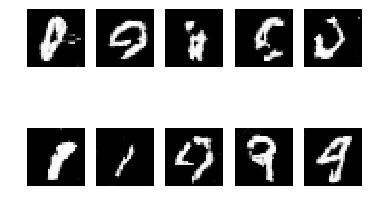

In [23]:
num_image = 10
for i in range(num_image):
    latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx).asnumpy()
    #label of "i : the index" class
    y_z_label = np.random.randint(i,i+1,1)

    y = np.zeros((1,28))
    y[np.arange(1),y_z_label] = 1
    y = y.reshape((1,28,1,1))

    latent_z = np.concatenate((latent_z,y) , axis = 1)
    latent_z = nd.array(latent_z, ctx = ctx)
    
    img = netG(latent_z)
    plt.subplot(2,5,i+1)
    visualize(img[0])
plt.show()

## End Model 2

# Conditional DCGANs

## Model 3
( Used, SGD optimizer with the Model 1 Architecture )

In [32]:
# build the generator
nc = 3
ngf = 28
netG = nn.Sequential()
with netG.name_scope():
    # input is Z, going into a convolution
    netG.add(nn.Conv2DTranspose(ngf * 8, 4, 1, 0, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 4 x 4
    netG.add(nn.Conv2DTranspose(ngf * 4, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*4) x 8 x 8
    netG.add(nn.Conv2DTranspose(ngf * 2, 3, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*2) x 15 x 15
    netG.add(nn.Conv2DTranspose(nc, 2, 2, 1, use_bias=False))
    netG.add(nn.Activation('tanh'))
    # state size. (nc) x 28 x 28

# build the discriminator
ndf = 28
netD = nn.Sequential()
with netD.name_scope():
    # input is (nc) x 29 x 28
    netD.add(nn.Conv2D(ndf, (4,3), 2, 1, use_bias=False))
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 14 x 14
    netD.add(nn.Conv2D(ndf * 2, 3, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf*2) x 7 x 7
    netD.add(nn.Conv2D(ndf * 4, 3, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf*8) x 4 x 4
    netD.add(nn.Conv2D(1, 4, 1, 0, use_bias=False))
    #state size. (1) x 1 x 1

In [33]:
# loss
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

# initialize the generator and the discriminator
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'sgd', {'learning_rate': lr})
trainerD = gluon.Trainer(netD.collect_params(), 'sgd', {'learning_rate': lr})



In [34]:
'''
def img_label_data(data,label):   #for image and label combine, not z and label
    data = data.asnumpy()
    label_temp = nd.array(label).asnumpy().astype(int)
    label = np.zeros((batch_size,28))
    label[np.arange(batch_size),label_temp]=1
    label = label.reshape((batch_size,1,1,28))
    label = np.tile(label, (1,3, 1, 1))
    return nd.array(np.concatenate((data,label),axis = 2), ctx = ctx)
'''


'\ndef img_label_data(data,label):   #for image and label combine, not z and label\n    data = data.asnumpy()\n    label_temp = nd.array(label).asnumpy().astype(int)\n    label = np.zeros((batch_size,28))\n    label[np.arange(batch_size),label_temp]=1\n    label = label.reshape((batch_size,1,1,28))\n    label = np.tile(label, (1,3, 1, 1))\n    return nd.array(np.concatenate((data,label),axis = 2), ctx = ctx)\n'

In [35]:
def img_label_data_nd(data,label):   #for image and label combine, not z and label
    label_temp = nd.array(label).astype(int)
    label = nd.zeros((batch_size,28))
    label[nd.arange(batch_size).astype(int),label_temp]=1
    label = label.reshape((batch_size,1,1,28))
    label = nd.tile(label, (1,3, 1, 1))
    return nd.array(nd.concat(data,label ,dim = 2), ctx = ctx)

In [36]:
i=0
train_data.reset()
for batch in train_data:
    if(i == 0):
        i+=1
    else:
        break
    data = batch.data[0]
    label = batch.label[0]
    print(img_label_data_nd(data,label).shape)

(64, 3, 29, 28)


In [37]:
from datetime import datetime
import time
import logging
import numpy as np

real_label = nd.ones((batch_size,), ctx=ctx)
fake_label = nd.zeros((batch_size,),ctx=ctx)

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()
metric = mx.metric.CustomMetric(facc)

stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
logging.basicConfig(level=logging.DEBUG)

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    train_data.reset()
    iter = 0
    for batch in train_data:
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        data = nd.array(batch.data[0])
        mnist_label = nd.array(batch.label[0])
        
        latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1)).asnumpy()
        y_z_label = np.random.randint(0,10,batch_size)
        
        y = np.zeros((batch_size,28))
        y[np.arange(batch_size),y_z_label] = 1
        y = y.reshape((batch_size,28,1,1))
        
        latent_z = np.concatenate((latent_z,y),axis = 1)
        latent_z = nd.array(latent_z, ctx = ctx)

        with autograd.record():
            # train with real image
            G_data = img_label_data_nd(data,mnist_label)
            
            output = netD(G_data).reshape((-1, 1))
            errD_real = loss(output, real_label)
            metric.update([real_label,], [output,])

            # train with fake image
            fake = netG(latent_z)
            
            G_fake_data = img_label_data_nd(fake.detach(),y_z_label)
            
            output = netD(G_fake_data).reshape((-1, 1))
            errD_fake = loss(output, fake_label)
            errD = errD_real + errD_fake
            errD.backward()
            metric.update([fake_label,], [output,])

        trainerD.step(batch.data[0].shape[0])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        
        with autograd.record():
            # train with fake image
            fake = netG(latent_z)
            G_fake_data = img_label_data_nd(fake,y_z_label)
            
            output = netD(G_fake_data).reshape((-1, 1))
            errG = loss(output, real_label)
            errG.backward()

        trainerG.step(batch.data[0].shape[0])
        
        # Print log infomation every ten batches
        if iter % 10 == 0:
            name, acc = metric.get()
            logging.info('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
            logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d'
                     %(nd.mean(errD).asscalar(),
                       nd.mean(errG).asscalar(), acc, iter, epoch))
        iter = iter + 1
        btic = time.time()

    name, acc = metric.get()
    metric.reset()
    # logging.info('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
    # logging.info('time: %f' % (time.time() - tic))

    # Visualize one generated image for each epoch
    # fake_img = fake[0]
    # visualize(fake_img)
    # plt.show()

INFO:root:speed: 330.58472269772733 samples/s
INFO:root:discriminator loss = 1.497579, generator loss = 0.697630, binary training acc = 0.437500 at iter 0 epoch 0
INFO:root:speed: 166.94640136226192 samples/s
INFO:root:discriminator loss = 1.163103, generator loss = 0.775684, binary training acc = 0.585227 at iter 10 epoch 0
INFO:root:speed: 179.4232318384709 samples/s
INFO:root:discriminator loss = 0.944887, generator loss = 0.859454, binary training acc = 0.720238 at iter 20 epoch 0
INFO:root:speed: 175.83726589515484 samples/s
INFO:root:discriminator loss = 0.825421, generator loss = 0.962430, binary training acc = 0.791835 at iter 30 epoch 0
INFO:root:speed: 186.96232343135023 samples/s
INFO:root:discriminator loss = 0.710717, generator loss = 1.050500, binary training acc = 0.834794 at iter 40 epoch 0
INFO:root:speed: 186.9466986746227 samples/s
INFO:root:discriminator loss = 0.676541, generator loss = 1.053739, binary training acc = 0.862132 at iter 50 epoch 0
INFO:root:speed: 17

INFO:root:speed: 185.23763802142096 samples/s
INFO:root:discriminator loss = 0.266864, generator loss = 2.104209, binary training acc = 0.977280 at iter 500 epoch 0
INFO:root:speed: 178.34560194320537 samples/s
INFO:root:discriminator loss = 0.222833, generator loss = 2.283530, binary training acc = 0.977510 at iter 510 epoch 0
INFO:root:speed: 184.0997354087311 samples/s
INFO:root:discriminator loss = 0.247677, generator loss = 2.178826, binary training acc = 0.977687 at iter 520 epoch 0
INFO:root:speed: 182.34308169371903 samples/s
INFO:root:discriminator loss = 0.235565, generator loss = 2.276388, binary training acc = 0.977872 at iter 530 epoch 0
INFO:root:speed: 183.80488579788104 samples/s
INFO:root:discriminator loss = 0.265025, generator loss = 2.104701, binary training acc = 0.978137 at iter 540 epoch 0
INFO:root:speed: 186.5757283415859 samples/s
INFO:root:discriminator loss = 0.228257, generator loss = 2.259033, binary training acc = 0.978434 at iter 550 epoch 0
INFO:root:sp

INFO:root:speed: 181.33781528954148 samples/s
INFO:root:discriminator loss = 0.157721, generator loss = 2.766953, binary training acc = 0.989882 at iter 60 epoch 1
INFO:root:speed: 183.9259131359474 samples/s
INFO:root:discriminator loss = 0.167406, generator loss = 2.866472, binary training acc = 0.989877 at iter 70 epoch 1
INFO:root:speed: 183.0860493080275 samples/s
INFO:root:discriminator loss = 0.140804, generator loss = 2.942396, binary training acc = 0.990066 at iter 80 epoch 1
INFO:root:speed: 173.9891173940858 samples/s
INFO:root:discriminator loss = 0.155300, generator loss = 2.904328, binary training acc = 0.990127 at iter 90 epoch 1
INFO:root:speed: 181.1981501869456 samples/s
INFO:root:discriminator loss = 0.180011, generator loss = 2.795977, binary training acc = 0.989635 at iter 100 epoch 1
INFO:root:speed: 163.9507748460416 samples/s
INFO:root:discriminator loss = 0.162376, generator loss = 2.731446, binary training acc = 0.989935 at iter 110 epoch 1
INFO:root:speed: 18

INFO:root:speed: 179.56041336250692 samples/s
INFO:root:discriminator loss = 0.244172, generator loss = 2.399717, binary training acc = 0.988957 at iter 560 epoch 1
INFO:root:speed: 180.84279937858656 samples/s
INFO:root:discriminator loss = 0.284823, generator loss = 2.445843, binary training acc = 0.988890 at iter 570 epoch 1
INFO:root:speed: 179.12128459173215 samples/s
INFO:root:discriminator loss = 0.240013, generator loss = 2.439533, binary training acc = 0.988772 at iter 580 epoch 1
INFO:root:speed: 182.21707713267304 samples/s
INFO:root:discriminator loss = 0.200557, generator loss = 2.479142, binary training acc = 0.988724 at iter 590 epoch 1
INFO:root:speed: 177.5525301531552 samples/s
INFO:root:discriminator loss = 0.264058, generator loss = 2.295087, binary training acc = 0.988730 at iter 600 epoch 1
INFO:root:speed: 181.15901892807707 samples/s
INFO:root:discriminator loss = 0.272589, generator loss = 2.366441, binary training acc = 0.988569 at iter 610 epoch 1
INFO:root:s

INFO:root:speed: 181.42789768115216 samples/s
INFO:root:discriminator loss = 0.179206, generator loss = 2.602202, binary training acc = 0.992188 at iter 120 epoch 2
INFO:root:speed: 182.4153219504173 samples/s
INFO:root:discriminator loss = 0.165678, generator loss = 2.833644, binary training acc = 0.992307 at iter 130 epoch 2
INFO:root:speed: 182.30803543534896 samples/s
INFO:root:discriminator loss = 0.173450, generator loss = 2.642980, binary training acc = 0.992188 at iter 140 epoch 2
INFO:root:speed: 184.11463531735689 samples/s
INFO:root:discriminator loss = 0.150282, generator loss = 2.789481, binary training acc = 0.992239 at iter 150 epoch 2
INFO:root:speed: 183.1232692054496 samples/s
INFO:root:discriminator loss = 0.162197, generator loss = 2.703654, binary training acc = 0.992285 at iter 160 epoch 2
INFO:root:speed: 182.66855208700517 samples/s
INFO:root:discriminator loss = 0.180884, generator loss = 2.747571, binary training acc = 0.992553 at iter 170 epoch 2
INFO:root:sp

INFO:root:speed: 176.0356011864439 samples/s
INFO:root:discriminator loss = 0.130016, generator loss = 3.008707, binary training acc = 0.993836 at iter 620 epoch 2
INFO:root:speed: 181.88631032319176 samples/s
INFO:root:discriminator loss = 0.167990, generator loss = 2.769050, binary training acc = 0.993834 at iter 630 epoch 2
INFO:root:speed: 183.4851392566689 samples/s
INFO:root:discriminator loss = 0.139651, generator loss = 2.915469, binary training acc = 0.993857 at iter 640 epoch 2
INFO:root:speed: 182.2715174544025 samples/s
INFO:root:discriminator loss = 0.145709, generator loss = 2.849852, binary training acc = 0.993880 at iter 650 epoch 2
INFO:root:speed: 182.45115352487267 samples/s
INFO:root:discriminator loss = 0.139080, generator loss = 2.825752, binary training acc = 0.993889 at iter 660 epoch 2
INFO:root:speed: 182.1248503130112 samples/s
INFO:root:discriminator loss = 0.167492, generator loss = 2.855020, binary training acc = 0.993852 at iter 670 epoch 2
INFO:root:spee

INFO:root:speed: 181.7867849524261 samples/s
INFO:root:discriminator loss = 0.146965, generator loss = 2.825053, binary training acc = 0.995338 at iter 180 epoch 3
INFO:root:speed: 167.3420908265757 samples/s
INFO:root:discriminator loss = 0.161009, generator loss = 2.776807, binary training acc = 0.995214 at iter 190 epoch 3
INFO:root:speed: 180.345995524194 samples/s
INFO:root:discriminator loss = 0.147936, generator loss = 2.911055, binary training acc = 0.995297 at iter 200 epoch 3
INFO:root:speed: 174.77950740045264 samples/s
INFO:root:discriminator loss = 0.132372, generator loss = 2.929002, binary training acc = 0.995039 at iter 210 epoch 3
INFO:root:speed: 182.45536992969872 samples/s
INFO:root:discriminator loss = 0.164165, generator loss = 2.995832, binary training acc = 0.994945 at iter 220 epoch 3
INFO:root:speed: 184.50110589816939 samples/s
INFO:root:discriminator loss = 0.135454, generator loss = 2.951444, binary training acc = 0.994927 at iter 230 epoch 3
INFO:root:spee

INFO:root:speed: 177.96959535165567 samples/s
INFO:root:discriminator loss = 0.156821, generator loss = 2.937413, binary training acc = 0.993725 at iter 680 epoch 3
INFO:root:speed: 182.55091130788884 samples/s
INFO:root:discriminator loss = 0.152474, generator loss = 3.049112, binary training acc = 0.993748 at iter 690 epoch 3
INFO:root:speed: 183.15725494182934 samples/s
INFO:root:discriminator loss = 0.120308, generator loss = 3.138856, binary training acc = 0.993748 at iter 700 epoch 3
INFO:root:speed: 183.3043385629172 samples/s
INFO:root:discriminator loss = 0.113399, generator loss = 3.214546, binary training acc = 0.993759 at iter 710 epoch 3
INFO:root:speed: 183.42107273488838 samples/s
INFO:root:discriminator loss = 0.203659, generator loss = 2.212108, binary training acc = 0.993661 at iter 720 epoch 3
INFO:root:speed: 181.32691342513317 samples/s
INFO:root:discriminator loss = 0.141410, generator loss = 3.163502, binary training acc = 0.993662 at iter 730 epoch 3
INFO:root:s

INFO:root:speed: 184.37615460275072 samples/s
INFO:root:discriminator loss = 0.188284, generator loss = 2.690934, binary training acc = 0.985996 at iter 240 epoch 4
INFO:root:speed: 183.30922038315035 samples/s
INFO:root:discriminator loss = 0.196061, generator loss = 3.063099, binary training acc = 0.985994 at iter 250 epoch 4
INFO:root:speed: 182.56556155639026 samples/s
INFO:root:discriminator loss = 0.230732, generator loss = 3.061942, binary training acc = 0.986081 at iter 260 epoch 4
INFO:root:speed: 181.9477057554035 samples/s
INFO:root:discriminator loss = 0.141722, generator loss = 3.071263, binary training acc = 0.986134 at iter 270 epoch 4
INFO:root:speed: 182.211140155755 samples/s
INFO:root:discriminator loss = 0.234385, generator loss = 2.737921, binary training acc = 0.985153 at iter 280 epoch 4
INFO:root:speed: 180.82915518669964 samples/s
INFO:root:discriminator loss = 0.228030, generator loss = 2.776794, binary training acc = 0.984992 at iter 290 epoch 4
INFO:root:spe

INFO:root:speed: 182.14956684121492 samples/s
INFO:root:discriminator loss = 0.161187, generator loss = 2.595550, binary training acc = 0.986094 at iter 740 epoch 4
INFO:root:speed: 177.52517098759472 samples/s
INFO:root:discriminator loss = 0.123804, generator loss = 2.923764, binary training acc = 0.986248 at iter 750 epoch 4
INFO:root:speed: 180.8820379020455 samples/s
INFO:root:discriminator loss = 0.143388, generator loss = 3.100158, binary training acc = 0.986377 at iter 760 epoch 4
INFO:root:speed: 180.19333721776349 samples/s
INFO:root:discriminator loss = 0.199540, generator loss = 2.136047, binary training acc = 0.986402 at iter 770 epoch 4
INFO:root:speed: 182.07728987569644 samples/s
INFO:root:discriminator loss = 0.130704, generator loss = 2.794746, binary training acc = 0.986456 at iter 780 epoch 4
INFO:root:speed: 179.23023703473228 samples/s
INFO:root:discriminator loss = 0.161559, generator loss = 3.257390, binary training acc = 0.986469 at iter 790 epoch 4
INFO:root:s

INFO:root:speed: 175.87355549178469 samples/s
INFO:root:discriminator loss = 0.189904, generator loss = 2.678487, binary training acc = 0.989826 at iter 300 epoch 5
INFO:root:speed: 182.68085908550498 samples/s
INFO:root:discriminator loss = 0.140488, generator loss = 3.153154, binary training acc = 0.989801 at iter 310 epoch 5
INFO:root:speed: 182.5028799556177 samples/s
INFO:root:discriminator loss = 0.134154, generator loss = 3.059746, binary training acc = 0.989997 at iter 320 epoch 5
INFO:root:speed: 180.68029936198124 samples/s
INFO:root:discriminator loss = 0.153749, generator loss = 2.806486, binary training acc = 0.990110 at iter 330 epoch 5
INFO:root:speed: 181.4530386665639 samples/s
INFO:root:discriminator loss = 0.161194, generator loss = 3.010224, binary training acc = 0.990126 at iter 340 epoch 5
INFO:root:speed: 181.07934126586343 samples/s
INFO:root:discriminator loss = 0.152086, generator loss = 3.198828, binary training acc = 0.990184 at iter 350 epoch 5
INFO:root:sp

INFO:root:speed: 168.61862550001004 samples/s
INFO:root:discriminator loss = 0.123010, generator loss = 3.242536, binary training acc = 0.992665 at iter 800 epoch 5
INFO:root:speed: 182.73644770234503 samples/s
INFO:root:discriminator loss = 0.130026, generator loss = 3.023598, binary training acc = 0.992708 at iter 810 epoch 5
INFO:root:speed: 180.9946079631154 samples/s
INFO:root:discriminator loss = 0.146530, generator loss = 3.360952, binary training acc = 0.992758 at iter 820 epoch 5
INFO:root:speed: 176.66480372658216 samples/s
INFO:root:discriminator loss = 0.455308, generator loss = 1.053877, binary training acc = 0.992554 at iter 830 epoch 5
INFO:root:speed: 182.3542299710269 samples/s
INFO:root:discriminator loss = 0.360373, generator loss = 3.070940, binary training acc = 0.990692 at iter 840 epoch 5
INFO:root:speed: 181.92292068354405 samples/s
INFO:root:discriminator loss = 0.157534, generator loss = 2.900231, binary training acc = 0.990553 at iter 850 epoch 5
INFO:root:sp

INFO:root:speed: 183.2639170696939 samples/s
INFO:root:discriminator loss = 0.134310, generator loss = 3.198267, binary training acc = 0.996105 at iter 360 epoch 6
INFO:root:speed: 181.70323333529635 samples/s
INFO:root:discriminator loss = 0.144822, generator loss = 2.770290, binary training acc = 0.996125 at iter 370 epoch 6
INFO:root:speed: 182.5818285698739 samples/s
INFO:root:discriminator loss = 0.124664, generator loss = 3.403422, binary training acc = 0.996145 at iter 380 epoch 6
INFO:root:speed: 181.80599176156488 samples/s
INFO:root:discriminator loss = 0.116630, generator loss = 3.270203, binary training acc = 0.996224 at iter 390 epoch 6
INFO:root:speed: 182.59114305051543 samples/s
INFO:root:discriminator loss = 0.178417, generator loss = 3.067822, binary training acc = 0.996240 at iter 400 epoch 6
INFO:root:speed: 181.80796192019116 samples/s
INFO:root:discriminator loss = 0.125268, generator loss = 3.141410, binary training acc = 0.996293 at iter 410 epoch 6
INFO:root:sp

INFO:root:speed: 180.25335277985943 samples/s
INFO:root:discriminator loss = 0.122521, generator loss = 3.284463, binary training acc = 0.991180 at iter 860 epoch 6
INFO:root:speed: 181.86437582146584 samples/s
INFO:root:discriminator loss = 0.121131, generator loss = 3.231067, binary training acc = 0.991264 at iter 870 epoch 6
INFO:root:speed: 181.36354398633603 samples/s
INFO:root:discriminator loss = 0.103727, generator loss = 3.306735, binary training acc = 0.991345 at iter 880 epoch 6
INFO:root:speed: 183.68904539476296 samples/s
INFO:root:discriminator loss = 0.157828, generator loss = 2.688825, binary training acc = 0.991425 at iter 890 epoch 6
INFO:root:speed: 183.9357433681559 samples/s
INFO:root:discriminator loss = 0.109009, generator loss = 3.217254, binary training acc = 0.991502 at iter 900 epoch 6
INFO:root:speed: 183.82288498069568 samples/s
INFO:root:discriminator loss = 0.122026, generator loss = 2.938274, binary training acc = 0.991587 at iter 910 epoch 6
INFO:root:s

INFO:root:speed: 181.33757028942625 samples/s
INFO:root:discriminator loss = 0.163631, generator loss = 3.004498, binary training acc = 0.973204 at iter 420 epoch 7
INFO:root:speed: 182.2126243637146 samples/s
INFO:root:discriminator loss = 0.122811, generator loss = 3.018353, binary training acc = 0.973771 at iter 430 epoch 7
INFO:root:speed: 181.7230375962653 samples/s
INFO:root:discriminator loss = 0.127861, generator loss = 2.903987, binary training acc = 0.974295 at iter 440 epoch 7
INFO:root:speed: 178.63827997519093 samples/s
INFO:root:discriminator loss = 0.129430, generator loss = 3.023439, binary training acc = 0.974848 at iter 450 epoch 7
INFO:root:speed: 182.6770052005711 samples/s
INFO:root:discriminator loss = 0.139956, generator loss = 3.339250, binary training acc = 0.975376 at iter 460 epoch 7
INFO:root:speed: 180.91227048608022 samples/s
INFO:root:discriminator loss = 0.153748, generator loss = 2.874594, binary training acc = 0.975849 at iter 470 epoch 7
INFO:root:spe

INFO:root:speed: 179.283266211171 samples/s
INFO:root:discriminator loss = 0.111872, generator loss = 3.244648, binary training acc = 0.986920 at iter 920 epoch 7
INFO:root:speed: 182.96687264761172 samples/s
INFO:root:discriminator loss = 0.098388, generator loss = 3.289158, binary training acc = 0.987044 at iter 930 epoch 7
INFO:root:speed: 167.31215614071064 samples/s
INFO:root:discriminator loss = 0.096678, generator loss = 3.626045, binary training acc = 1.000000 at iter 0 epoch 8
INFO:root:speed: 182.87064632556212 samples/s
INFO:root:discriminator loss = 0.119289, generator loss = 3.823575, binary training acc = 0.999290 at iter 10 epoch 8
INFO:root:speed: 183.67899014532262 samples/s
INFO:root:discriminator loss = 0.161795, generator loss = 2.082540, binary training acc = 0.997768 at iter 20 epoch 8
INFO:root:speed: 183.42057141217236 samples/s
INFO:root:discriminator loss = 3.834075, generator loss = 4.111115, binary training acc = 0.930192 at iter 30 epoch 8
INFO:root:speed: 

INFO:root:speed: 182.92971629195105 samples/s
INFO:root:discriminator loss = 0.087055, generator loss = 3.180548, binary training acc = 0.952557 at iter 480 epoch 8
INFO:root:speed: 180.34708600559782 samples/s
INFO:root:discriminator loss = 0.065961, generator loss = 3.710715, binary training acc = 0.953491 at iter 490 epoch 8
INFO:root:speed: 182.4717413485219 samples/s
INFO:root:discriminator loss = 0.090843, generator loss = 3.845558, binary training acc = 0.954373 at iter 500 epoch 8
INFO:root:speed: 179.70718827532005 samples/s
INFO:root:discriminator loss = 0.058714, generator loss = 3.872506, binary training acc = 0.955220 at iter 510 epoch 8
INFO:root:speed: 184.23202482274127 samples/s
INFO:root:discriminator loss = 0.119174, generator loss = 2.676224, binary training acc = 0.956049 at iter 520 epoch 8
INFO:root:speed: 184.92830565630888 samples/s
INFO:root:discriminator loss = 0.120915, generator loss = 2.664391, binary training acc = 0.956877 at iter 530 epoch 8
INFO:root:s

INFO:root:speed: 181.24182595250795 samples/s
INFO:root:discriminator loss = 0.135508, generator loss = 3.234216, binary training acc = 0.966845 at iter 40 epoch 9
INFO:root:speed: 182.72002875214076 samples/s
INFO:root:discriminator loss = 0.138264, generator loss = 3.325186, binary training acc = 0.973039 at iter 50 epoch 9
INFO:root:speed: 175.39779853871897 samples/s
INFO:root:discriminator loss = 0.143178, generator loss = 3.494040, binary training acc = 0.977075 at iter 60 epoch 9
INFO:root:speed: 182.57810304370005 samples/s
INFO:root:discriminator loss = 0.107470, generator loss = 3.165092, binary training acc = 0.980084 at iter 70 epoch 9
INFO:root:speed: 182.72388445261888 samples/s
INFO:root:discriminator loss = 0.069242, generator loss = 3.778537, binary training acc = 0.982253 at iter 80 epoch 9
INFO:root:speed: 183.07006688267535 samples/s
INFO:root:discriminator loss = 0.107586, generator loss = 3.082937, binary training acc = 0.984032 at iter 90 epoch 9
INFO:root:speed:

INFO:root:speed: 171.05568070085332 samples/s
INFO:root:discriminator loss = 0.108564, generator loss = 3.313446, binary training acc = 0.963652 at iter 540 epoch 9
INFO:root:speed: 182.61772559392244 samples/s
INFO:root:discriminator loss = 0.090245, generator loss = 3.546890, binary training acc = 0.964298 at iter 550 epoch 9
INFO:root:speed: 181.81042467852117 samples/s
INFO:root:discriminator loss = 0.089877, generator loss = 3.662053, binary training acc = 0.964934 at iter 560 epoch 9
INFO:root:speed: 181.93993657343364 samples/s
INFO:root:discriminator loss = 0.127316, generator loss = 3.243274, binary training acc = 0.965507 at iter 570 epoch 9
INFO:root:speed: 181.6193898421595 samples/s
INFO:root:discriminator loss = 0.105044, generator loss = 3.876619, binary training acc = 0.966061 at iter 580 epoch 9
INFO:root:speed: 183.3879913127657 samples/s
INFO:root:discriminator loss = 0.079575, generator loss = 3.711702, binary training acc = 0.966622 at iter 590 epoch 9
INFO:root:sp

INFO:root:speed: 182.4341658681129 samples/s
INFO:root:discriminator loss = 0.468022, generator loss = 2.378135, binary training acc = 0.946860 at iter 100 epoch 10
INFO:root:speed: 182.78422870341115 samples/s
INFO:root:discriminator loss = 0.365341, generator loss = 2.786811, binary training acc = 0.944609 at iter 110 epoch 10
INFO:root:speed: 181.53132692422136 samples/s
INFO:root:discriminator loss = 0.185065, generator loss = 2.495113, binary training acc = 0.946346 at iter 120 epoch 10
INFO:root:speed: 179.71260225494797 samples/s
INFO:root:discriminator loss = 0.114930, generator loss = 3.233444, binary training acc = 0.950203 at iter 130 epoch 10
INFO:root:speed: 182.24936621716856 samples/s
INFO:root:discriminator loss = 0.134986, generator loss = 2.869920, binary training acc = 0.953568 at iter 140 epoch 10
INFO:root:speed: 181.1020642503574 samples/s
INFO:root:discriminator loss = 0.093438, generator loss = 3.401579, binary training acc = 0.956643 at iter 150 epoch 10
INFO:r

INFO:root:speed: 180.15197879265796 samples/s
INFO:root:discriminator loss = 0.244330, generator loss = 2.292140, binary training acc = 0.952176 at iter 600 epoch 10
INFO:root:speed: 179.68373146586896 samples/s
INFO:root:discriminator loss = 0.170312, generator loss = 2.836387, binary training acc = 0.952741 at iter 610 epoch 10
INFO:root:speed: 180.41314530009888 samples/s
INFO:root:discriminator loss = 0.198280, generator loss = 2.210490, binary training acc = 0.953301 at iter 620 epoch 10
INFO:root:speed: 179.9936138869127 samples/s
INFO:root:discriminator loss = 0.234120, generator loss = 1.972782, binary training acc = 0.953942 at iter 630 epoch 10
INFO:root:speed: 179.46581607718417 samples/s
INFO:root:discriminator loss = 0.309823, generator loss = 1.337127, binary training acc = 0.954356 at iter 640 epoch 10
INFO:root:speed: 179.99735538076752 samples/s
INFO:root:discriminator loss = 0.174300, generator loss = 2.748391, binary training acc = 0.954889 at iter 650 epoch 10
INFO:

INFO:root:speed: 178.753430094266 samples/s
INFO:root:discriminator loss = 0.377147, generator loss = 1.572501, binary training acc = 0.914257 at iter 160 epoch 11
INFO:root:speed: 174.00659893146576 samples/s
INFO:root:discriminator loss = 0.292033, generator loss = 1.714064, binary training acc = 0.917809 at iter 170 epoch 11
INFO:root:speed: 177.00671072786702 samples/s
INFO:root:discriminator loss = 0.145777, generator loss = 2.866083, binary training acc = 0.921961 at iter 180 epoch 11
INFO:root:speed: 176.4702692788355 samples/s
INFO:root:discriminator loss = 0.206848, generator loss = 3.255540, binary training acc = 0.925720 at iter 190 epoch 11
INFO:root:speed: 178.1274903200762 samples/s
INFO:root:discriminator loss = 0.152913, generator loss = 3.237731, binary training acc = 0.928677 at iter 200 epoch 11
INFO:root:speed: 164.4686025323839 samples/s
INFO:root:discriminator loss = 0.176861, generator loss = 2.605925, binary training acc = 0.931946 at iter 210 epoch 11
INFO:root

INFO:root:speed: 165.165436498463 samples/s
INFO:root:discriminator loss = 0.127438, generator loss = 2.944082, binary training acc = 0.955572 at iter 660 epoch 11
INFO:root:speed: 186.9618025640472 samples/s
INFO:root:discriminator loss = 0.098155, generator loss = 3.531324, binary training acc = 0.956234 at iter 670 epoch 11
INFO:root:speed: 184.569228727665 samples/s
INFO:root:discriminator loss = 0.202820, generator loss = 1.835890, binary training acc = 0.956785 at iter 680 epoch 11
INFO:root:speed: 166.46499363746184 samples/s
INFO:root:discriminator loss = 0.125056, generator loss = 2.786501, binary training acc = 0.957410 at iter 690 epoch 11
INFO:root:speed: 185.67365317920675 samples/s
INFO:root:discriminator loss = 0.076459, generator loss = 3.713638, binary training acc = 0.958006 at iter 700 epoch 11
INFO:root:speed: 178.85395079101104 samples/s
INFO:root:discriminator loss = 0.093175, generator loss = 3.412670, binary training acc = 0.958542 at iter 710 epoch 11
INFO:root

INFO:root:speed: 179.00219855550168 samples/s
INFO:root:discriminator loss = 0.358565, generator loss = 1.693599, binary training acc = 0.936510 at iter 220 epoch 12
INFO:root:speed: 178.94838114437172 samples/s
INFO:root:discriminator loss = 0.364825, generator loss = 1.148591, binary training acc = 0.938413 at iter 230 epoch 12
INFO:root:speed: 179.77735466177322 samples/s
INFO:root:discriminator loss = 0.145069, generator loss = 2.953662, binary training acc = 0.937500 at iter 240 epoch 12
INFO:root:speed: 178.5689997532029 samples/s
INFO:root:discriminator loss = 0.152198, generator loss = 2.523169, binary training acc = 0.939897 at iter 250 epoch 12
INFO:root:speed: 185.8397309418282 samples/s
INFO:root:discriminator loss = 0.160386, generator loss = 2.490288, binary training acc = 0.942020 at iter 260 epoch 12
INFO:root:speed: 178.0335698842006 samples/s
INFO:root:discriminator loss = 0.142489, generator loss = 3.572429, binary training acc = 0.944131 at iter 270 epoch 12
INFO:ro

INFO:root:speed: 178.72546161871657 samples/s
INFO:root:discriminator loss = 0.184109, generator loss = 2.435509, binary training acc = 0.960742 at iter 720 epoch 12
INFO:root:speed: 178.44542710895433 samples/s
INFO:root:discriminator loss = 0.090041, generator loss = 3.302762, binary training acc = 0.961269 at iter 730 epoch 12
INFO:root:speed: 179.46905570561336 samples/s
INFO:root:discriminator loss = 0.077323, generator loss = 3.420081, binary training acc = 0.961770 at iter 740 epoch 12
INFO:root:speed: 177.687805898403 samples/s
INFO:root:discriminator loss = 0.067621, generator loss = 3.565580, binary training acc = 0.962279 at iter 750 epoch 12
INFO:root:speed: 174.2781823965928 samples/s
INFO:root:discriminator loss = 0.071122, generator loss = 3.568568, binary training acc = 0.962765 at iter 760 epoch 12
INFO:root:speed: 159.89055495660773 samples/s
INFO:root:discriminator loss = 0.120214, generator loss = 2.743675, binary training acc = 0.963238 at iter 770 epoch 12
INFO:ro

INFO:root:speed: 179.0547345517319 samples/s
INFO:root:discriminator loss = 0.150310, generator loss = 2.419605, binary training acc = 0.982067 at iter 280 epoch 13
INFO:root:speed: 174.72069275024424 samples/s
INFO:root:discriminator loss = 0.101697, generator loss = 3.062227, binary training acc = 0.982684 at iter 290 epoch 13
INFO:root:speed: 183.667930642356 samples/s
INFO:root:discriminator loss = 0.079158, generator loss = 3.578753, binary training acc = 0.983233 at iter 300 epoch 13
INFO:root:speed: 179.14064954600116 samples/s
INFO:root:discriminator loss = 0.052536, generator loss = 3.861300, binary training acc = 0.983722 at iter 310 epoch 13
INFO:root:speed: 159.2193918314158 samples/s
INFO:root:discriminator loss = 0.051305, generator loss = 4.205041, binary training acc = 0.984205 at iter 320 epoch 13
INFO:root:speed: 183.968014079507 samples/s
INFO:root:discriminator loss = 0.071773, generator loss = 3.949282, binary training acc = 0.984682 at iter 330 epoch 13
INFO:root:

INFO:root:speed: 183.64330289890964 samples/s
INFO:root:discriminator loss = 0.719836, generator loss = 1.117700, binary training acc = 0.968240 at iter 780 epoch 13
INFO:root:speed: 161.80011765727016 samples/s
INFO:root:discriminator loss = 0.315576, generator loss = 2.288929, binary training acc = 0.967980 at iter 790 epoch 13
INFO:root:speed: 182.1081704481006 samples/s
INFO:root:discriminator loss = 1.378482, generator loss = 4.430999, binary training acc = 0.966673 at iter 800 epoch 13
INFO:root:speed: 182.25320207947607 samples/s
INFO:root:discriminator loss = 0.263402, generator loss = 2.803016, binary training acc = 0.965687 at iter 810 epoch 13
INFO:root:speed: 172.6448449424443 samples/s
INFO:root:discriminator loss = 0.224675, generator loss = 3.740111, binary training acc = 0.965962 at iter 820 epoch 13
INFO:root:speed: 164.3152747112161 samples/s
INFO:root:discriminator loss = 0.381264, generator loss = 3.723332, binary training acc = 0.964877 at iter 830 epoch 13
INFO:ro

INFO:root:speed: 152.73006251205493 samples/s
INFO:root:discriminator loss = 0.070622, generator loss = 3.410974, binary training acc = 0.977548 at iter 340 epoch 14
INFO:root:speed: 163.10521023149497 samples/s
INFO:root:discriminator loss = 0.068510, generator loss = 4.203993, binary training acc = 0.978165 at iter 350 epoch 14
INFO:root:speed: 176.5964645899806 samples/s
INFO:root:discriminator loss = 0.087108, generator loss = 3.083471, binary training acc = 0.978727 at iter 360 epoch 14
INFO:root:speed: 161.56843692350287 samples/s
INFO:root:discriminator loss = 0.078622, generator loss = 3.617558, binary training acc = 0.979300 at iter 370 epoch 14
INFO:root:speed: 182.1655125612454 samples/s
INFO:root:discriminator loss = 0.052716, generator loss = 4.253170, binary training acc = 0.979802 at iter 380 epoch 14
INFO:root:speed: 183.98390147880488 samples/s
INFO:root:discriminator loss = 0.042658, generator loss = 4.221281, binary training acc = 0.980319 at iter 390 epoch 14
INFO:r

INFO:root:speed: 184.36298502214262 samples/s
INFO:root:discriminator loss = 0.107021, generator loss = 3.653684, binary training acc = 0.968295 at iter 840 epoch 14
INFO:root:speed: 183.3754635869487 samples/s
INFO:root:discriminator loss = 0.085033, generator loss = 3.590180, binary training acc = 0.968658 at iter 850 epoch 14
INFO:root:speed: 182.75809537296382 samples/s
INFO:root:discriminator loss = 0.089436, generator loss = 3.520737, binary training acc = 0.969022 at iter 860 epoch 14
INFO:root:speed: 182.92846969608172 samples/s
INFO:root:discriminator loss = 0.085373, generator loss = 3.642729, binary training acc = 0.969378 at iter 870 epoch 14
INFO:root:speed: 180.6201207384261 samples/s
INFO:root:discriminator loss = 0.072696, generator loss = 3.618759, binary training acc = 0.969725 at iter 880 epoch 14
INFO:root:speed: 182.35881354711694 samples/s
INFO:root:discriminator loss = 0.120969, generator loss = 2.961641, binary training acc = 0.970056 at iter 890 epoch 14
INFO:r

INFO:root:speed: 185.71064789511917 samples/s
INFO:root:discriminator loss = 0.073513, generator loss = 3.538432, binary training acc = 0.981959 at iter 400 epoch 15
INFO:root:speed: 186.9757367640196 samples/s
INFO:root:discriminator loss = 0.075341, generator loss = 3.297334, binary training acc = 0.982379 at iter 410 epoch 15
INFO:root:speed: 186.1894372952551 samples/s
INFO:root:discriminator loss = 0.038678, generator loss = 4.215344, binary training acc = 0.982779 at iter 420 epoch 15
INFO:root:speed: 151.88859956159558 samples/s
INFO:root:discriminator loss = 0.055967, generator loss = 3.945220, binary training acc = 0.983161 at iter 430 epoch 15
INFO:root:speed: 187.76016876598268 samples/s
INFO:root:discriminator loss = 0.061013, generator loss = 3.826238, binary training acc = 0.983525 at iter 440 epoch 15
INFO:root:speed: 187.2471510314323 samples/s
INFO:root:discriminator loss = 0.089834, generator loss = 4.077335, binary training acc = 0.983890 at iter 450 epoch 15
INFO:ro

INFO:root:speed: 185.2928752427161 samples/s
INFO:root:discriminator loss = 0.094197, generator loss = 2.253059, binary training acc = 0.983465 at iter 900 epoch 15
INFO:root:speed: 184.57735100476165 samples/s
INFO:root:discriminator loss = 0.072479, generator loss = 3.320814, binary training acc = 0.983646 at iter 910 epoch 15
INFO:root:speed: 184.59105896850332 samples/s
INFO:root:discriminator loss = 0.107243, generator loss = 2.637059, binary training acc = 0.983824 at iter 920 epoch 15
INFO:root:speed: 186.8029433583067 samples/s
INFO:root:discriminator loss = 0.361281, generator loss = 2.188066, binary training acc = 0.982101 at iter 930 epoch 15
INFO:root:speed: 185.5355671150542 samples/s
INFO:root:discriminator loss = 2.187324, generator loss = 4.123198, binary training acc = 0.523438 at iter 0 epoch 16
INFO:root:speed: 185.8037136453556 samples/s
INFO:root:discriminator loss = 0.405289, generator loss = 2.025796, binary training acc = 0.791903 at iter 10 epoch 16
INFO:root:s

INFO:root:speed: 186.1077257783392 samples/s
INFO:root:discriminator loss = 0.057983, generator loss = 4.284794, binary training acc = 0.971495 at iter 460 epoch 16
INFO:root:speed: 186.3900829131894 samples/s
INFO:root:discriminator loss = 0.085729, generator loss = 3.508830, binary training acc = 0.972067 at iter 470 epoch 16
INFO:root:speed: 186.66875470695695 samples/s
INFO:root:discriminator loss = 0.064627, generator loss = 3.442983, binary training acc = 0.972599 at iter 480 epoch 16
INFO:root:speed: 170.4742839469872 samples/s
INFO:root:discriminator loss = 0.063460, generator loss = 4.067519, binary training acc = 0.973078 at iter 490 epoch 16
INFO:root:speed: 171.2606320366924 samples/s
INFO:root:discriminator loss = 0.051949, generator loss = 4.046736, binary training acc = 0.973600 at iter 500 epoch 16
INFO:root:speed: 187.8099563910269 samples/s
INFO:root:discriminator loss = 6.022079, generator loss = 0.588821, binary training acc = 0.969499 at iter 510 epoch 16
INFO:root

INFO:root:speed: 180.19986923137856 samples/s
INFO:root:discriminator loss = 0.054267, generator loss = 3.944620, binary training acc = 1.000000 at iter 20 epoch 17
INFO:root:speed: 182.0707445397861 samples/s
INFO:root:discriminator loss = 0.052866, generator loss = 4.258210, binary training acc = 1.000000 at iter 30 epoch 17
INFO:root:speed: 185.81940517955093 samples/s
INFO:root:discriminator loss = 0.077140, generator loss = 3.238420, binary training acc = 1.000000 at iter 40 epoch 17
INFO:root:speed: 184.21255485672916 samples/s
INFO:root:discriminator loss = 0.051497, generator loss = 3.974474, binary training acc = 0.999847 at iter 50 epoch 17
INFO:root:speed: 183.390747642162 samples/s
INFO:root:discriminator loss = 0.097858, generator loss = 4.200451, binary training acc = 0.999872 at iter 60 epoch 17
INFO:root:speed: 182.10421715026905 samples/s
INFO:root:discriminator loss = 0.039444, generator loss = 4.226365, binary training acc = 0.999890 at iter 70 epoch 17
INFO:root:spe

INFO:root:speed: 185.20159815319613 samples/s
INFO:root:discriminator loss = 0.408398, generator loss = 1.738895, binary training acc = 0.959198 at iter 520 epoch 17
INFO:root:speed: 184.67716105312618 samples/s
INFO:root:discriminator loss = 0.373131, generator loss = 1.828549, binary training acc = 0.959378 at iter 530 epoch 17
INFO:root:speed: 185.54890475630916 samples/s
INFO:root:discriminator loss = 0.247585, generator loss = 2.347212, binary training acc = 0.959768 at iter 540 epoch 17
INFO:root:speed: 184.82033416115112 samples/s
INFO:root:discriminator loss = 0.189607, generator loss = 2.912836, binary training acc = 0.960073 at iter 550 epoch 17
INFO:root:speed: 171.8652380601769 samples/s
INFO:root:discriminator loss = 0.114781, generator loss = 3.277043, binary training acc = 0.960743 at iter 560 epoch 17
INFO:root:speed: 156.94960209410002 samples/s
INFO:root:discriminator loss = 0.183268, generator loss = 3.699489, binary training acc = 0.960992 at iter 570 epoch 17
INFO:

INFO:root:speed: 185.8699705236977 samples/s
INFO:root:discriminator loss = 0.315339, generator loss = 5.815237, binary training acc = 0.998457 at iter 80 epoch 18
INFO:root:speed: 184.737658312131 samples/s
INFO:root:discriminator loss = 0.043371, generator loss = 4.109742, binary training acc = 0.998111 at iter 90 epoch 18
INFO:root:speed: 179.48729579664715 samples/s
INFO:root:discriminator loss = 0.070419, generator loss = 3.534782, binary training acc = 0.998298 at iter 100 epoch 18
INFO:root:speed: 185.61497999923938 samples/s
INFO:root:discriminator loss = 0.148826, generator loss = 5.047348, binary training acc = 0.997537 at iter 110 epoch 18
INFO:root:speed: 185.75909729127872 samples/s
INFO:root:discriminator loss = 0.068960, generator loss = 3.624185, binary training acc = 0.996965 at iter 120 epoch 18
INFO:root:speed: 185.0860329525459 samples/s
INFO:root:discriminator loss = 0.030824, generator loss = 4.488966, binary training acc = 0.997137 at iter 130 epoch 18
INFO:root:

INFO:root:speed: 181.9343875639465 samples/s
INFO:root:discriminator loss = 0.073548, generator loss = 4.272259, binary training acc = 0.975850 at iter 580 epoch 18
INFO:root:speed: 182.1279395122004 samples/s
INFO:root:discriminator loss = 0.076352, generator loss = 3.806549, binary training acc = 0.976206 at iter 590 epoch 18
INFO:root:speed: 181.0534489026602 samples/s
INFO:root:discriminator loss = 0.058434, generator loss = 4.092404, binary training acc = 0.976511 at iter 600 epoch 18
INFO:root:speed: 181.7023723783892 samples/s
INFO:root:discriminator loss = 0.086444, generator loss = 4.309257, binary training acc = 0.976793 at iter 610 epoch 18
INFO:root:speed: 180.0004935278119 samples/s
INFO:root:discriminator loss = 0.054496, generator loss = 4.131302, binary training acc = 0.977154 at iter 620 epoch 18
INFO:root:speed: 182.79306594866534 samples/s
INFO:root:discriminator loss = 0.044508, generator loss = 4.417549, binary training acc = 0.977491 at iter 630 epoch 18
INFO:root

INFO:root:speed: 181.5429900455353 samples/s
INFO:root:discriminator loss = 0.197283, generator loss = 3.220933, binary training acc = 0.979111 at iter 140 epoch 19
INFO:root:speed: 180.47512743868086 samples/s
INFO:root:discriminator loss = 0.151922, generator loss = 2.686545, binary training acc = 0.979770 at iter 150 epoch 19
INFO:root:speed: 181.95362557751122 samples/s
INFO:root:discriminator loss = 0.130757, generator loss = 3.152923, binary training acc = 0.979862 at iter 160 epoch 19
INFO:root:speed: 179.27129300039402 samples/s
INFO:root:discriminator loss = 0.150190, generator loss = 2.550291, binary training acc = 0.980720 at iter 170 epoch 19
INFO:root:speed: 179.93232381663537 samples/s
INFO:root:discriminator loss = 0.106631, generator loss = 3.271847, binary training acc = 0.981656 at iter 180 epoch 19
INFO:root:speed: 181.01572282088284 samples/s
INFO:root:discriminator loss = 0.095353, generator loss = 3.409151, binary training acc = 0.982453 at iter 190 epoch 19
INFO:

INFO:root:speed: 181.42728457341832 samples/s
INFO:root:discriminator loss = 0.275582, generator loss = 2.860210, binary training acc = 0.976940 at iter 640 epoch 19
INFO:root:speed: 164.92058009479837 samples/s
INFO:root:discriminator loss = 0.200582, generator loss = 2.288162, binary training acc = 0.977115 at iter 650 epoch 19
INFO:root:speed: 182.5303056162814 samples/s
INFO:root:discriminator loss = 0.180484, generator loss = 3.417552, binary training acc = 0.977343 at iter 660 epoch 19
INFO:root:speed: 180.63008695207475 samples/s
INFO:root:discriminator loss = 0.227087, generator loss = 3.808526, binary training acc = 0.977145 at iter 670 epoch 19
INFO:root:speed: 182.21645867952603 samples/s
INFO:root:discriminator loss = 0.145418, generator loss = 2.831501, binary training acc = 0.977377 at iter 680 epoch 19
INFO:root:speed: 180.94080565992206 samples/s
INFO:root:discriminator loss = 0.145262, generator loss = 3.059922, binary training acc = 0.977614 at iter 690 epoch 19
INFO:

## 1 image generated of each class, from 0 - 9

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matp

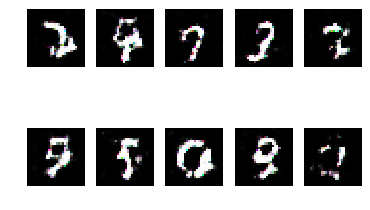

In [38]:
num_image = 10
for i in range(num_image):
    latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx).asnumpy()
    #label of "i : the index" class
    y_z_label = np.random.randint(i,i+1,1)

    y = np.zeros((1,28))
    y[np.arange(1),y_z_label] = 1
    y = y.reshape((1,28,1,1))

    latent_z = np.concatenate((latent_z,y) , axis = 1)
    latent_z = nd.array(latent_z, ctx = ctx)
    
    img = netG(latent_z)
    plt.subplot(2,5,i+1)
    visualize(img[0])
plt.show()

## End Model 3